In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from IPython.display import display
from time import time
from math import log2
import os
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNC

from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix


# Some variables to set for plotting

fig_folder = os.getcwd()+"\\figures\\breastcancer\\" # make sure this path exists!
fig_folder
# Convenience function for saving plots
def savefig(name, fig_folder=fig_folder):
    print(f"Saving figure at <{fig_folder + name}>")
    plt.savefig(fig_folder + name)

# Contents

1) [Data exploration](#dataexp)

2) [Preprocessing](#preproc)

3) [Training](#train)

4) [Results](#results)

<a id='dataexp'></a>
# 1. Dataset

In [2]:
df_full = pd.read_csv('Datasets/breastcancer/breast-cancer-diagnostic.shuf.lrn.csv')
df = df_full.copy()
df.head()

,ID,class,radiusMean,textureMean,perimeterMean,areaMean,smoothnessMean,compactnessMean,concavityMean,concavePointsMean,...,radiusWorst,textureWorst,perimeterWorst,areaWorst,smoothnessWorst,compactnessWorst,concavityWorst,concavePointsWorst,symmetryWorst,fractalDimensionWorst
0,868682,B,11.43,15.39,73.06,399.8,0.09639,0.06889,0.03503,0.02875,...,12.32,22.02,79.93,462.0,0.1190,0.1648,0.1399,0.08476,0.2676,0.06765
1,881972,M,17.05,19.08,113.40,895.0,0.11410,0.15720,0.19100,0.10900,...,19.59,24.89,133.50,1189.0,0.1703,0.3934,0.5018,0.25430,0.3109,0.09061
2,901315,B,10.57,20.22,70.15,338.3,0.09073,0.16600,0.22800,0.05941,...,10.85,22.82,76.51,351.9,0.1143,0.3619,0.6030,0.14650,0.2597,0.12000
3,9112367,B,13.21,25.25,84.10,537.9,0.08791,0.05205,0.02772,0.02068,...,14.35,34.23,91.29,632.9,0.1289,0.1063,0.1390,0.06005,0.2444,0.06788
4,8711202,M,17.68,20.74,117.40,963.7,0.11150,0.16650,0.18550,0.10540,...,20.47,25.11,132.90,1302.0,0.1418,0.3498,0.3583,0.15150,0.2463,0.07738


In [3]:
num_samples, num_features = df.shape
num_features -= 2 # class and id aren't features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       285 non-null    int64  
 1   class                    285 non-null    object 
 2   radiusMean               285 non-null    float64
 3    textureMean             285 non-null    float64
 4    perimeterMean           285 non-null    float64
 5    areaMean                285 non-null    float64
 6    smoothnessMean          285 non-null    float64
 7    compactnessMean         285 non-null    float64
 8    concavityMean           285 non-null    float64
 9    concavePointsMean       285 non-null    float64
 10   symmetryMean            285 non-null    float64
 11   fractalDimensionMean    285 non-null    float64
 12   radiusStdErr            285 non-null    float64
 13   textureStdErr           285 non-null    float64
 14   perimeterStdErr         2

## Goal

The goal of the dataset is to be able to classify the type of cancer based on various input data (about the breasts).

## Classes:

B... benign

M... malignant

We will later also use the mapping/encoding:

$B \rightarrow 0$

$M \rightarrow 1$

In [4]:
def encode(data,  feature, val:tuple, val_else=1):
    """encode s.t val[0] is mapped to val[1] and rest to else"""
    res = data.copy()
    res[feature] = res[feature].apply(lambda x: val[1] if x==val[0] else val_else)
    return(res)

In [5]:
pd.isnull(df.any())

ID                         False
class                      False
radiusMean                 False
 textureMean               False
 perimeterMean             False
 areaMean                  False
 smoothnessMean            False
 compactnessMean           False
 concavityMean             False
 concavePointsMean         False
 symmetryMean              False
 fractalDimensionMean      False
 radiusStdErr              False
 textureStdErr             False
 perimeterStdErr           False
 areaStdErr                False
 smoothnessStdErr          False
 compactnessStdErr         False
 concavityStdErr           False
 concavePointsStdErr       False
 symmetryStdErr            False
 fractalDimensionStdErr    False
 radiusWorst               False
 textureWorst              False
 perimeterWorst            False
 areaWorst                 False
 smoothnessWorst           False
 compactnessWorst          False
 concavityWorst            False
 concavePointsWorst        False
 symmetryW

Conclusio: no missing values

In [6]:
df.describe()

,ID,radiusMean,textureMean,perimeterMean,areaMean,smoothnessMean,compactnessMean,concavityMean,concavePointsMean,symmetryMean,...,radiusWorst,textureWorst,perimeterWorst,areaWorst,smoothnessWorst,compactnessWorst,concavityWorst,concavePointsWorst,symmetryWorst,fractalDimensionWorst
count,2.850000e+02,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,...,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000
mean,3.024415e+07,13.857832,19.310000,90.076070,625.102105,0.095960,0.101917,0.084848,0.046362,0.180695,...,15.823884,25.665825,104.135123,823.488421,0.132186,0.249617,0.265468,0.112228,0.290091,0.083933
std,1.295562e+08,3.252277,4.277718,22.227367,310.526144,0.013481,0.048350,0.073680,0.034868,0.028748,...,4.361540,6.128468,29.847173,482.465945,0.022661,0.151791,0.201241,0.063620,0.067542,0.018766
min,8.670000e+03,7.729000,9.710000,47.920000,178.800000,0.052630,0.023440,0.000000,0.000000,0.106000,...,8.952000,12.020000,56.650000,240.100000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.711490e+05,11.570000,16.170000,74.200000,409.100000,0.086370,0.064920,0.030460,0.021680,0.161900,...,12.840000,21.190000,83.850000,505.600000,0.117200,0.146000,0.116800,0.063430,0.247700,0.072070
50%,9.055020e+05,13.150000,18.910000,84.450000,536.900000,0.095940,0.092180,0.059280,0.032640,0.177800,...,14.670000,25.440000,96.310000,657.000000,0.130300,0.211900,0.210200,0.099100,0.280400,0.079440
75%,8.711561e+06,15.490000,21.800000,102.500000,748.900000,0.104600,0.129600,0.120400,0.065760,0.195300,...,18.070000,30.360000,121.200000,989.500000,0.146100,0.341600,0.382900,0.156100,0.316800,0.091870
max,9.113205e+08,27.220000,33.810000,182.100000,2250.000000,0.142500,0.283900,0.410800,0.187800,0.304000,...,33.120000,45.410000,220.800000,3216.000000,0.222600,1.058000,1.105000,0.273300,0.663800,0.207500


In [7]:
def describe_cols(dataframe, n=3):
    for col in dataframe.columns:
        print("-"*40)
        print(f"Column: {col}")
        print(f"Top {n} vals")
        counts = dataframe[col].value_counts()
        print(counts.iloc[0:min(len(counts),3)])
        print("# of unique values: ", dataframe[col].nunique())

In [8]:
describe_cols(df)

----------------------------------------
Column: ID
Top 3 vals
91789       1
88147102    1
852631      1
Name: ID, dtype: int64
# of unique values:  285
----------------------------------------
Column: class
Top 3 vals
B    189
M     96
Name: class, dtype: int64
# of unique values:  2
----------------------------------------
Column: radiusMean
Top 3 vals
10.26    3
12.05    2
13.87    2
Name: radiusMean, dtype: int64
# of unique values:  253
----------------------------------------
Column:  textureMean
Top 3 vals
18.22    3
16.85    3
21.68    2
Name:  textureMean, dtype: int64
# of unique values:  261
----------------------------------------
Column:  perimeterMean
Top 3 vals
87.76     3
82.61     2
107.10    2
Name:  perimeterMean, dtype: int64
# of unique values:  274
----------------------------------------
Column:  areaMean
Top 3 vals
466.1    2
321.6    2
716.6    2
Name:  areaMean, dtype: int64
# of unique values:  277
----------------------------------------
Column:  smoothnessM

## Features

Information is presented on:

- radius
- texture
- perimeter
- area
- smoothness
- compactness
- concavity
- concavePoints
- symmetry
- fractalDimension

However, that information is split into 3 seperate categories/types per "base feature" (above):

- Mean
- Standard error/deviation (StdErr)
- Worst

While Mean and StdErr are self explanatory, we don't really understand what "Worst" means in this context...it doesn't really matter to us and in fact it might help us with staying unbiased when exploring the data further.

In [9]:
cols = df.columns

In [10]:
# Some column names have " " (spaces) in front of them --> strip them

new_cols = []
for ele in cols:
    new_cols.append(ele.strip(" "))
new_cols

['ID',
 'class',
 'radiusMean',
 'textureMean',
 'perimeterMean',
 'areaMean',
 'smoothnessMean',
 'compactnessMean',
 'concavityMean',
 'concavePointsMean',
 'symmetryMean',
 'fractalDimensionMean',
 'radiusStdErr',
 'textureStdErr',
 'perimeterStdErr',
 'areaStdErr',
 'smoothnessStdErr',
 'compactnessStdErr',
 'concavityStdErr',
 'concavePointsStdErr',
 'symmetryStdErr',
 'fractalDimensionStdErr',
 'radiusWorst',
 'textureWorst',
 'perimeterWorst',
 'areaWorst',
 'smoothnessWorst',
 'compactnessWorst',
 'concavityWorst',
 'concavePointsWorst',
 'symmetryWorst',
 'fractalDimensionWorst']

In [11]:
df.columns = new_cols

ID = df.columns[0]
clas = df.columns[1]
feats = df.columns[2:]

In [12]:
#feats_mean = df.columns
feats_mean = [feat for feat in feats if 'Mean' in feat ]
feats_mean

['radiusMean',
 'textureMean',
 'perimeterMean',
 'areaMean',
 'smoothnessMean',
 'compactnessMean',
 'concavityMean',
 'concavePointsMean',
 'symmetryMean',
 'fractalDimensionMean']

In [13]:
feats_Std = [feat for feat in feats if 'Std' in feat ]
feats_Std

['radiusStdErr',
 'textureStdErr',
 'perimeterStdErr',
 'areaStdErr',
 'smoothnessStdErr',
 'compactnessStdErr',
 'concavityStdErr',
 'concavePointsStdErr',
 'symmetryStdErr',
 'fractalDimensionStdErr']

In [14]:
feats_Worst = [feat for feat in feats if 'Worst' in feat ]
feats_Worst

['radiusWorst',
 'textureWorst',
 'perimeterWorst',
 'areaWorst',
 'smoothnessWorst',
 'compactnessWorst',
 'concavityWorst',
 'concavePointsWorst',
 'symmetryWorst',
 'fractalDimensionWorst']

In [15]:
# For visualizations
dfM=df[df[clas] == 'M']
dfB=df[df[clas] == 'B']

In [16]:
# Count occurence of M/B
count_classes = df[clas].value_counts()
count_classes

B    189
M     96
Name: class, dtype: int64

In [17]:
# Percentages
dist_classes = count_classes.apply(lambda x: x/num_samples)
dist_classes

B    0.663158
M    0.336842
Name: class, dtype: float64

# 2. Preprocessing/Feature selection
<a id='preproc'></a>

In [18]:
# Colors
sns_cols = sns.color_palette()
snsblue, snsgreen = sns_cols[0], sns_cols[1]

Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\class_dist.png>


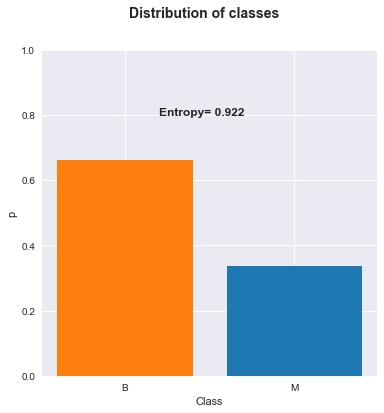

In [19]:
plt.rcParams.update({'font.size': 12})
mpl.style.use('seaborn')
fig = plt.figure(figsize=(6,6))
plt.bar(dist_classes.index, dist_classes, color=[snsgreen, snsblue])
plt.suptitle("Distribution of classes", fontsize=14, weight="bold")
plt.ylim((0,1))
plt.ylabel("p")
plt.xlabel("Class")

entropy = -sum([p*log2(p) for p in dist_classes])
plt.annotate(f"Entropy= {entropy:.3f}", (0.2, 0.8), fontweight="bold")

savefig("class_dist.png")

(Luckily) benign cancer seems to be more prevalent than maligned.

For us, this means the dataset is skewed towards more class 'B' samples.
The overall entropy of the set is 0.922, where entropy=1 would be a perfectly evenly distributed set.


Next, we will plot the distribution of each feature when seperated into 2 groups based on their class (B or M)

In [20]:
def plot_hist_type(df, list_feats, feature_type, stacked=True):
    mpl.style.use('seaborn')
    plt.rcParams.update({'font.size': 8})
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16,10))
    fig.suptitle(f"Features {feature_type}", x=0.5, y=1, fontsize=14, weight="bold")
    axes = axes.ravel() # easoer to iterate over
    for index,ax in enumerate(axes):
        ax.figure
        binwidth= (max(df[list_feats[index]]) - min(df[list_feats[index]]))/50
        ax.hist([dfM[list_feats[index]],dfB[list_feats[index]]], bins=np.arange(min(df[list_feats[index]]), max(df[list_feats[index]]) + binwidth, binwidth), alpha=1, stacked=stacked, label=['M','B'], density=True) #, color=['xkcd:light yellow','b']
        ax.legend(loc='upper right')
        ax.set_title(list_feats[index])
    plt.tight_layout()


Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\features_mean_dist.png>


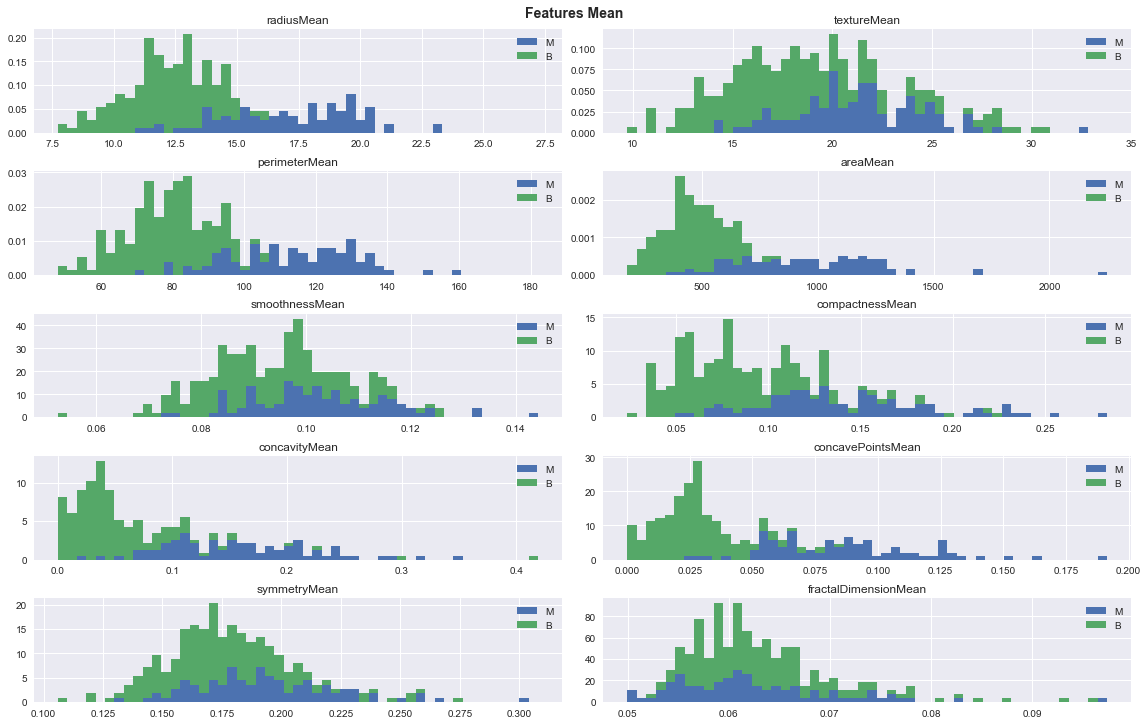

In [21]:
plot_hist_type(df, feats_mean, 'Mean')
savefig("features_mean_dist.png")
plt.show()

## Conlusio Mean features

At first glance, there are several notable differences between the distributions for "M" and "B":

For all features but "symmetryMean", "fractalDimensionMean" and "smoothnessMean", the distributions skew towards higher values for "M" than for "B".

We will therefore consider dropping these 3, as they do not seem to be good indicators.

Consider to drop (so far):

\["symmetryMean", "fractalDimensionMean", "smoothnessMean"]

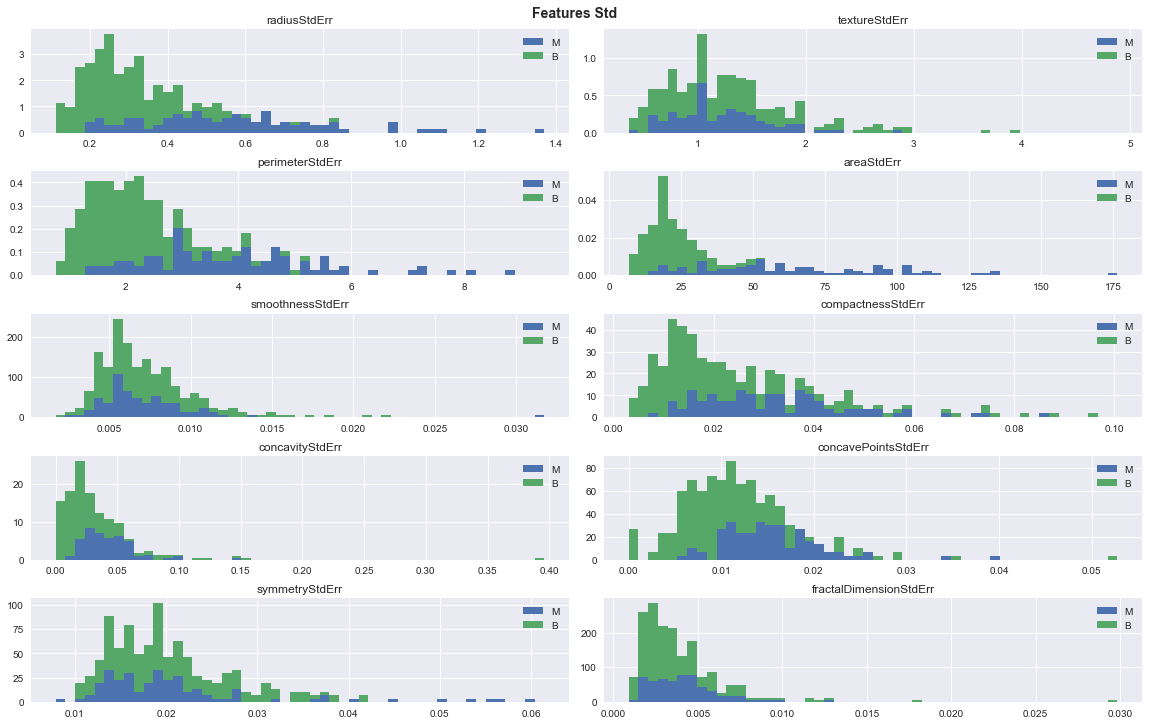

In [22]:
plot_hist_type(df, feats_Std, 'Std')
plt.savefig(fig_folder + "features_std_dist.png")
plt.show()

## Conclusio StdErr features

These featuers seem to overall not be too good indicators. Some do not seem to be bad indicators, these are considered for dropping again and are added to the list.

Consider to drop (so far):

\["symmetryMean", "fractalDimensionMean", "smoothnessMean"] + \["textureStdErr", "smoothnessStdErr", "concavityStdErr", "symmetryStdErr", "fractalDimensionStdErr"]

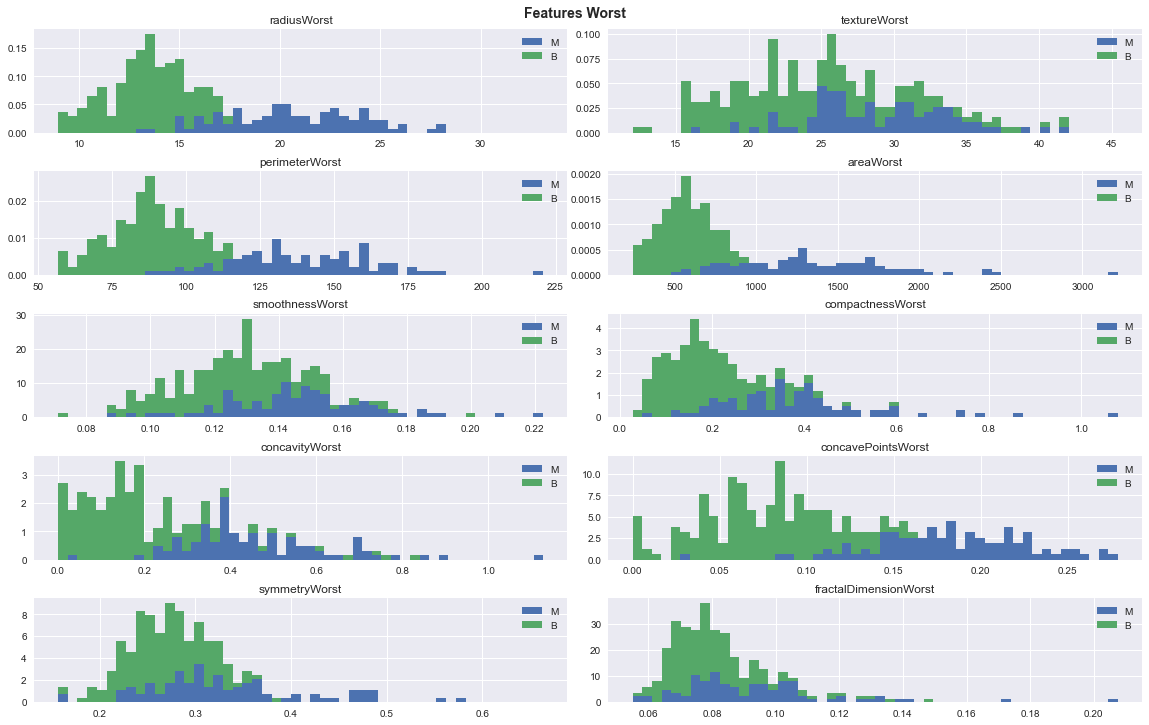

In [23]:
plot_hist_type(df, feats_Worst, 'Worst')
plt.savefig(fig_folder + "features_worst_dist.png")
plt.show()

# Conclusio "Worst" features

Same procedure as above.

Consider to drop (so far):

\["symmetryMean", "fractalDimensionMean", "smoothnessMean"] + \["textureStdErr", "smoothnessStdErr", "concavityStdErr", "symmetryStdErr", "fractalDimensionStdErr"] + \["textureWorst", "smoothnessWorst", "symmetryWorst", "fractalDimensionWorst"]

In [24]:
feats_to_drop_hist = ["symmetryMean", "fractalDimensionMean", "smoothnessMean"] + ["textureStdErr", "smoothnessStdErr", "concavityStdErr", "symmetryStdErr", "fractalDimensionStdErr"] + ["textureWorst", "smoothnessWorst", "symmetryWorst", "fractalDimensionWorst"]
feats_to_drop_hist

['symmetryMean',
 'fractalDimensionMean',
 'smoothnessMean',
 'textureStdErr',
 'smoothnessStdErr',
 'concavityStdErr',
 'symmetryStdErr',
 'fractalDimensionStdErr',
 'textureWorst',
 'smoothnessWorst',
 'symmetryWorst',
 'fractalDimensionWorst']

In [25]:
df_changed = encode(df, clas, ('B', 0), 1)
df_changed


# B...0
# M...1

,ID,class,radiusMean,textureMean,perimeterMean,areaMean,smoothnessMean,compactnessMean,concavityMean,concavePointsMean,...,radiusWorst,textureWorst,perimeterWorst,areaWorst,smoothnessWorst,compactnessWorst,concavityWorst,concavePointsWorst,symmetryWorst,fractalDimensionWorst
0,868682,0,11.43,15.39,73.06,399.8,0.09639,0.06889,0.03503,0.028750,...,12.32,22.02,79.93,462.0,0.1190,0.16480,0.13990,0.08476,0.2676,0.06765
1,881972,1,17.05,19.08,113.40,895.0,0.11410,0.15720,0.19100,0.109000,...,19.59,24.89,133.50,1189.0,0.1703,0.39340,0.50180,0.25430,0.3109,0.09061
2,901315,0,10.57,20.22,70.15,338.3,0.09073,0.16600,0.22800,0.059410,...,10.85,22.82,76.51,351.9,0.1143,0.36190,0.60300,0.14650,0.2597,0.12000
3,9112367,0,13.21,25.25,84.10,537.9,0.08791,0.05205,0.02772,0.020680,...,14.35,34.23,91.29,632.9,0.1289,0.10630,0.13900,0.06005,0.2444,0.06788
4,8711202,1,17.68,20.74,117.40,963.7,0.11150,0.16650,0.18550,0.105400,...,20.47,25.11,132.90,1302.0,0.1418,0.34980,0.35830,0.15150,0.2463,0.07738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,869691,1,11.80,16.58,78.99,432.0,0.10910,0.17000,0.16590,0.074150,...,13.74,26.38,91.93,591.7,0.1385,0.40920,0.45040,0.18650,0.5774,0.10300
281,871149,0,10.90,12.96,68.69,366.8,0.07515,0.03718,0.00309,0.006588,...,12.36,18.20,78.07,470.0,0.1171,0.08294,0.01854,0.03953,0.2738,0.07685
282,84667401,1,13.73,22.61,93.60,578.3,0.11310,0.22930,0.21280,0.080250,...,15.03,32.01,108.80,697.7,0.1651,0.77250,0.69430,0.22080,0.3596,0.14310
283,912558,0,13.70,17.64,87.76,571.1,0.09950,0.07957,0.04548,0.031600,...,14.96,23.53,95.78,686.5,0.1199,0.13460,0.17420,0.09077,0.2518,0.06960


In [186]:
def plot_corr_heatmap(df, fmt=".2f", feat_to_ret="class", ticksfont=12):
    plt.rcParams.update({'font.size': 14, 'font.weight': 'bold'})
    # Compute correlations and save in matrix
    corr = np.abs(df.corr()) # We only used absolute values for visualization purposes! ..."hot-cold" view to just sort between 
    # Mask the repeated values --> here: upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True # mask upper triangle

    corr_to_feat = corr.loc[:,feat_to_ret]
    
    f, ax = plt.subplots(figsize=(18, 16))
    sns.heatmap(corr, annot=True, fmt=fmt , mask=mask, vmin=0, vmax=1, linewidths=.5)
    plt.tick_params(labelsize=ticksfont)
    return corr_to_feat

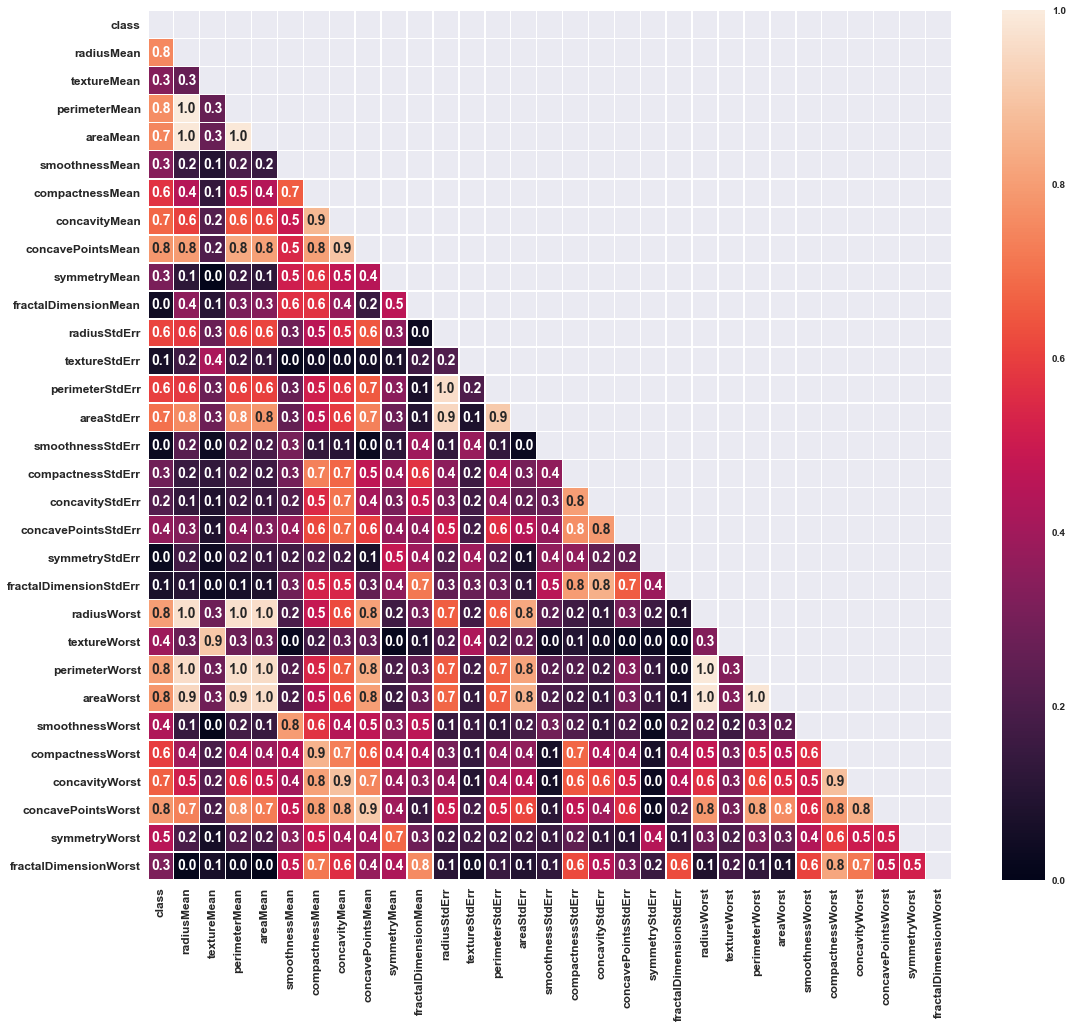

In [180]:
corr_to_class = plot_corr_heatmap(df_changed.drop("ID", axis=1), fmt=".1f", feat_to_ret=clas)
plt.savefig(fig_folder + "corr_matrix_full.png")
plt.show()

In [138]:
# Show only correlations to class
corr_to_class

class                     1.000000
radiusMean                0.751062
textureMean               0.333695
perimeterMean             0.764998
areaMean                  0.747269
smoothnessMean            0.339849
compactnessMean           0.573574
concavityMean             0.681731
concavePointsMean         0.787229
symmetryMean              0.312038
fractalDimensionMean      0.045533
radiusStdErr              0.612123
textureStdErr             0.061687
perimeterStdErr           0.600798
areaStdErr                0.701987
smoothnessStdErr          0.030609
compactnessStdErr         0.288182
concavityStdErr           0.219059
concavePointsStdErr       0.365539
symmetryStdErr            0.027132
fractalDimensionStdErr    0.073940
radiusWorst               0.801456
textureWorst              0.391978
perimeterWorst            0.809883
areaWorst                 0.781390
smoothnessWorst           0.432201
compactnessWorst          0.597553
concavityWorst            0.664461
concavePointsWorst  

In [139]:
# We are thinking about droping:
feats_to_drop = feats_to_drop_hist + ["perimeterMean", "areaMean", "perimeterWorst", "areaWorst", "perimeterStdErr", "areaStdErr", "radiusWorst"]
df_reduced = df_changed.drop(feats_to_drop, axis=1)
print("Final number of selected features:", df_reduced.shape[1] - 2)

Final number of selected features: 11


features to drop:
["symmetryMean", "fractalDimensionMean", "smoothnessMean"] + ["textureStdErr", "smoothnessStdErr", "concavityStdErr", "symmetryStdErr", "fractalDimensionStdErr"] + ["textureWorst", "smoothnessWorst", "symmetryWorst", "fractalDimensionWorst"] + ["perimeterMean", "areaMean", "perimeterWorst", "areaWorst", "perimeterStdErr", "areaStdErr", "radiusWorst"]

## Conclusio of Correlation Heatmap

If we compare our results from the histograms with the correlation plot, we notice that although most features we selected for dropping seem to be a good choice (for dropping), there are some that seem to correlate surprisingly well with the class!

1) Specifically, the "Mean" and "StdErr" features to be dropped, do NOT correlate well with the class (according to the heatmap above). This agrees with our findings from before.

2) The "Worst" features correlate higher with the class than we expected (based on the histograms). The ones we selected for dropping also have lower correlation scores than the others, but they aren't as bad as the "Mean" and "StdErr" values, that we selected for dropping.

3) The features "radiusMean/Worst", "perimeterMean/Worst" and "areaMean/Worst" all correlate highly with each other. This isn't at all surprising since the area and perimeter of a circle/sphere are all directly linked to the radius (basic geometric relation). --> We will also drop all Mean/Worst versions of perimeter and area.
## Decision

We will drop all proposed features for now and check the performance.

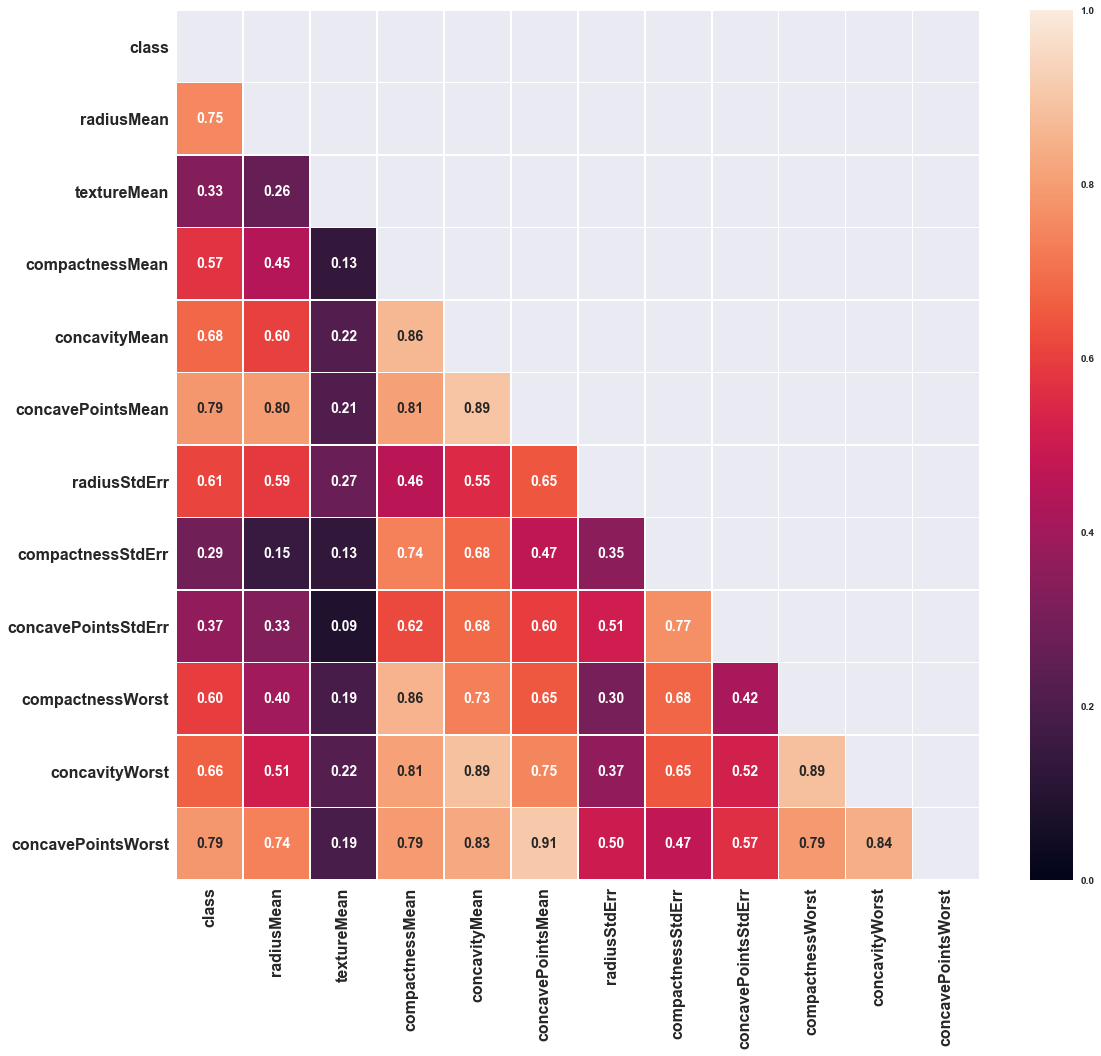

In [191]:
# Heatmap of reduced df
corr_to_class_stripped = plot_corr_heatmap(df_reduced.drop("ID", axis=1), ticksfont=16)
plt.savefig(fig_folder + "corr_matrix_reduced.png")
plt.show()

In [31]:
# The df we will use for the rest:
df = df.drop(feats_to_drop, axis=1)
df.head()

,ID,class,radiusMean,textureMean,compactnessMean,concavityMean,concavePointsMean,radiusStdErr,compactnessStdErr,concavePointsStdErr,compactnessWorst,concavityWorst,concavePointsWorst
0,868682,B,11.43,15.39,0.06889,0.03503,0.02875,0.1759,0.015210,0.008602,0.1648,0.1399,0.08476
1,881972,M,17.05,19.08,0.15720,0.19100,0.10900,0.2959,0.020080,0.013840,0.3934,0.5018,0.25430
2,901315,B,10.57,20.22,0.16600,0.22800,0.05941,0.1115,0.076430,0.029190,0.3619,0.6030,0.14650
3,9112367,B,13.21,25.25,0.05205,0.02772,0.02068,0.2084,0.008082,0.006451,0.1063,0.1390,0.06005
4,8711202,M,17.68,20.74,0.16650,0.18550,0.10540,0.8113,0.049540,0.018410,0.3498,0.3583,0.15150


In [32]:
# The features we will use
feats = df.columns[2:]
feats

Index(['radiusMean', 'textureMean', 'compactnessMean', 'concavityMean',
       'concavePointsMean', 'radiusStdErr', 'compactnessStdErr',
       'concavePointsStdErr', 'compactnessWorst', 'concavityWorst',
       'concavePointsWorst'],
      dtype='object')

## Scale features

Scaler: StandardScaler

Some Classifiers need scaled features/ work much better (e.g. kNN --> otherwise distances would be "weighted"), for others (e.g. randomForst) it shouldn't make a difference either way.

In [33]:
scaled_features = StandardScaler().fit_transform(df[feats].values)
df[feats] = scaled_features
df_MB = df.copy()
df_MB

,ID,class,radiusMean,textureMean,compactnessMean,concavityMean,concavePointsMean,radiusStdErr,compactnessStdErr,concavePointsStdErr,compactnessWorst,concavityWorst,concavePointsWorst
0,868682,B,-0.747815,-0.917988,-0.684283,-0.677338,-0.505998,-0.981918,-0.606683,-0.541445,-0.559757,-0.625066,-0.432503
1,881972,M,0.983244,-0.053862,1.145409,1.443253,1.799579,-0.408980,-0.326410,0.266467,0.948905,1.176435,2.237070
2,901315,B,-1.012710,0.213104,1.327736,1.946310,0.374862,-1.289394,2.916579,2.634060,0.741019,1.680198,0.539653
3,9112367,B,-0.199544,1.391033,-1.033190,-0.776726,-0.737848,-0.826747,-1.016905,-0.873216,-0.945832,-0.629546,-0.821587
4,8711202,M,1.177296,0.334878,1.338095,1.368474,1.696152,2.051787,1.369037,0.971346,0.661164,0.462107,0.618383
...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,869691,M,-0.633849,-0.639313,1.410611,1.101989,0.798341,-0.295348,0.608791,0.974431,1.053179,0.920571,1.169492
281,871149,B,-0.911064,-1.487047,-1.341281,-1.111599,-1.142711,-0.476300,-1.129014,-1.316658,-1.099998,-1.229183,-1.144694
282,84667401,M,-0.039374,0.772796,2.639246,1.739649,0.973594,-0.809082,1.934187,0.642814,3.450804,2.134680,1.709579
283,912558,B,-0.048615,-0.391082,-0.463004,-0.535258,-0.424118,-0.661073,-1.010920,-0.444119,-0.759064,-0.454324,-0.337870


In [34]:
# Here we apply the encoding of the class possibilites (B...0, M...1)
df = encode(df, clas, val=("B", 0), val_else=1)
df

,ID,class,radiusMean,textureMean,compactnessMean,concavityMean,concavePointsMean,radiusStdErr,compactnessStdErr,concavePointsStdErr,compactnessWorst,concavityWorst,concavePointsWorst
0,868682,0,-0.747815,-0.917988,-0.684283,-0.677338,-0.505998,-0.981918,-0.606683,-0.541445,-0.559757,-0.625066,-0.432503
1,881972,1,0.983244,-0.053862,1.145409,1.443253,1.799579,-0.408980,-0.326410,0.266467,0.948905,1.176435,2.237070
2,901315,0,-1.012710,0.213104,1.327736,1.946310,0.374862,-1.289394,2.916579,2.634060,0.741019,1.680198,0.539653
3,9112367,0,-0.199544,1.391033,-1.033190,-0.776726,-0.737848,-0.826747,-1.016905,-0.873216,-0.945832,-0.629546,-0.821587
4,8711202,1,1.177296,0.334878,1.338095,1.368474,1.696152,2.051787,1.369037,0.971346,0.661164,0.462107,0.618383
...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,869691,1,-0.633849,-0.639313,1.410611,1.101989,0.798341,-0.295348,0.608791,0.974431,1.053179,0.920571,1.169492
281,871149,0,-0.911064,-1.487047,-1.341281,-1.111599,-1.142711,-0.476300,-1.129014,-1.316658,-1.099998,-1.229183,-1.144694
282,84667401,1,-0.039374,0.772796,2.639246,1.739649,0.973594,-0.809082,1.934187,0.642814,3.450804,2.134680,1.709579
283,912558,0,-0.048615,-0.391082,-0.463004,-0.535258,-0.424118,-0.661073,-1.010920,-0.444119,-0.759064,-0.454324,-0.337870


In [35]:
## PCA

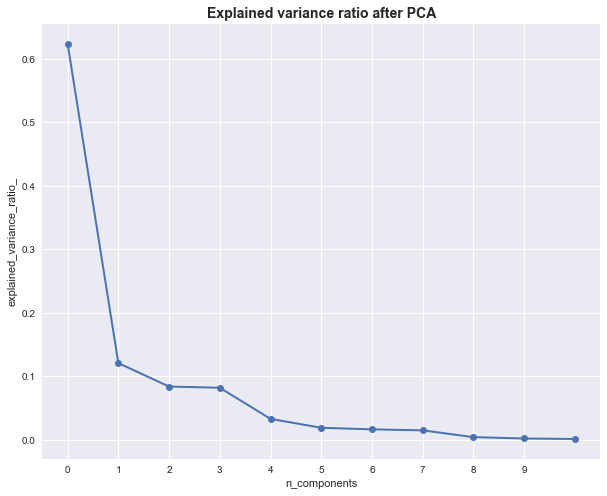

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components=11)
pca.fit(df[feats])

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10, 8))
plt.title("Explained variance ratio after PCA", fontsize=14, fontweight="bold")
#plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2, marker="o")
#plt.axis('tight')
plt.xlabel('n_components')
plt.xticks(range(0,10))
plt.ylabel('explained_variance_ratio_')

plt.savefig(fig_folder + "pca_explained_variance.png")

# Define a process function

This function takes input data and applies processing as described above:

1) Strip column names of unwanted chars (spaces, etc)

2) Drop certain features as specified (optional)

3) Scale the features with a given Scaler (optional)

4) Perform a PCA (optional)

5) Return the new dataframe with the processed data AND a dictionary with the columns (names) sorted into ID, class and features

In [37]:
def process_data_bc(data, features_to_drop=feats_to_drop, scaler=StandardScaler(), num_pca=0, class_in_data=True):
    df_ret = data.copy()

    # Strip columns of unwanted chars
    cols = df_ret.columns
    new_cols = []
    for ele in cols:
        new_cols.append(ele.strip())
    df_ret.columns = new_cols

    # Drop unwanted features
    if features_to_drop:
        df_ret = df_ret.drop(features_to_drop, axis=1)

    i = 0
    ID = df_ret.columns[i]
    i += 1
    if class_in_data:
        clas = df_ret.columns[i]
        i += 1
    feats = df_ret.columns[i:]

    # Scale
    if scaler:
        scaled_features = scaler.fit_transform(df_ret[feats].values)
        df_ret[feats] = scaled_features

    if num_pca:
        pca = PCA(n_components=num_pca)
        pca_feats = pca.fit_transform(df_ret[feats])
        cols_not_pca = ID
        if class_in_data:
            cols_not_pca = [ID, clas]   
        df_pca = pd.concat([df_ret[cols_not_pca], pd.DataFrame(pca_feats, columns=["pca"+str(i) for i in range(pca_feats.shape[1])])], axis=1)
        df_ret = df_pca.copy()
        # redo binding of ID, class, features names
        i = 0
        ID = df_ret.columns[i]
        i += 1
        if class_in_data:
            clas = df_ret.columns[i]
            i += 1
        feats = df_ret.columns[i:]

    if num_pca:
        if class_in_data:
            df_pca = encode(df_pca, clas, val=("B", 0), val_else=1)
            return df_pca, {"ID": ID, "class": clas, "features": feats}
        else:
            return df_pca, {"ID": ID, "features": feats}
    else:
        if class_in_data:
            df_ret = encode(df_ret, clas, val=("B", 0), val_else=1)
            return df_ret, {"ID": ID, "class": clas, "features": feats}
        else:
            return df_ret, {"ID": ID, "features": feats}

# Quick test
# print("features to drop:", feats_to_drop)
# df_ret, cols_ret = process_data_bc(df_full, features_to_drop=feats_to_drop)
# print("cols returned:", cols_ret)
# df_ret.head()

# 3. Model training
<a id='train'></a>
## Scores/Metrics

Next, we will define some metrics we used for evaluation and some functions to display them.

### Confusion matrix

The confusion matrix allows visualization of the performance of an algorithm :

- True Positive (TP) : Malignant tumour correctly identified as malignant
- True Negative (TN) : Benign tumour correctly identified as benign
- False Positive (FP) : Benign tumour incorrectly identified as malignant
- False Negative (FN) : Malignant tumour incorrectly identified as benign

In our case (binary classification), the matrix will be 2x2. If there were more classes, the matrix would be num_classes x num_classes.

### Metrics :

Accuracy : $\frac{(TP +TN)} {TP + TN + FP +FN}$

Precision : $\frac{TP} {TP + FP}$

Recall : $\frac{TP} {TP + FN}$

F1-score: $2 \frac{Recall\ *\ Precision}{Recall\ +\ Precision}$


In [38]:
metrics_explanation = {
"TP": "true positive (TP) : Malignant tumour correctly identified as malignant",
"TN": "true negative (TN) : Benign tumour correctly identified as benign",
"FP": "false positive (FP) : Benign tumour incorrectly identified as malignant",
"FN": "false negative (FN) : Malignant tumour incorrectly identified as benign",
"Accuracy" : "Accuracy: (TP +TN) / (TP + TN + FP +FN)",
"Precision" : "Precision: TP / (TP + FP)",
"Recall" : "Recall: TP / (TP + FN)"
}

In [39]:
import itertools

# Confusion matrix 
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Reds) :
    """classes are the possible classes, so e.g ["B","M"], s.t. the ordering matches the encoding"""
    plt.rcParams.update({'font.size': 12})
    num_samples = 1
    if normalize:
        num_samples = np.sum(cm)
    print("#",num_samples)
    plt.imshow(cm, interpolation = "nearest", cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2
    # itertools.product() gives all combinations of the iterables
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        string = cm[i, j]
        if normalize:
            string /= num_samples
            string = f"{string:.2f}"
        plt.text(j, i, string, horizontalalignment = "center", color="black", backgroundcolor="white")#= "white" if cm[i, j] > thresh else "black", )
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    
# Show metrics 
def show_metrics(cm):
    """also returns the metrics as dict"""
    tn = cm[0,0]
    tp = cm[1,1]

    fp = cm[0,1]
    fn = cm[1,0]

    acc = (tp+tn) / (tp+tn+fp+fn)
    prec = tp / (tp+fp)
    rec = tp / (tp+fn)
    f1 = 2 * (prec * rec) / (prec + rec)
    print(f"Accuracy  =     {acc:.3f}")
    print(f"Precision =     {prec:.3f}")
    print(f"Recall    =     {rec:.3f}")
    print(f"F1_score  =     {f1:.3f}")
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}


## Cross traination metrics

Cross-traination is a technique to evaluate predictive models by partitioning the original sample into a training set to train the model, and a test set to evaluate it.


In [40]:
from sklearn.model_selection import cross_val_score, cross_val_predict

# Cross val metric
def cross_val_metrics(model, X, y, cv=5, explain=False, show=True):
    scores = ["accuracy", "precision", "recall"]
    metrics = {}
    for sc in scores:
        scores = cross_val_score(model, X, y, cv=cv, scoring=sc)
        if show:
            print(f"[{sc}] : {scores.mean():0.5f} (+/- {scores.std():0.5f})")
        metrics[sc] = scores.mean()
    metrics["f1"] = 2 * (metrics["recall"] * metrics["precision"])/(metrics["recall"] +  metrics["precision"])
    f1 = metrics["f1"]
    if show:
        print(f"[f1] :  {f1}")
    if explain:
        print("")
        for key in metrics_explanation:
            print(metrics_explanation[key])
    return metrics

# ROC curve

The receiver operating characteristic (ROC) curve is another common tool used with
binary classifiers. It is very similar to the precision/recall curve, but instead of plot‐
ting precision versus recall, the ROC curve plots the true positive rate (another name
for recall) against the false positive rate. The FPR is the ratio of negative instances that
are incorrectly classified as positive. 

In [41]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--', label="purely random") # dashed diagonal

# Train-Test(/traination)-Splitting

In [42]:
feats_to_drop

['symmetryMean',
 'fractalDimensionMean',
 'smoothnessMean',
 'textureStdErr',
 'smoothnessStdErr',
 'concavityStdErr',
 'symmetryStdErr',
 'fractalDimensionStdErr',
 'textureWorst',
 'smoothnessWorst',
 'symmetryWorst',
 'fractalDimensionWorst',
 'perimeterMean',
 'areaMean',
 'perimeterWorst',
 'areaWorst',
 'perimeterStdErr',
 'areaStdErr',
 'radiusWorst']

In [43]:
# Here we drop all proposed features
df, cols = process_data_bc(df_full, features_to_drop=feats_to_drop, scaler=StandardScaler(), num_pca=0, class_in_data=True)
# Here we take the full feature set
df_nodrop, cols_nodrop = process_data_bc(df_full, features_to_drop=None, scaler=StandardScaler(), num_pca=0, class_in_data=True)
print("cols:", cols)
df.head()

cols: {'ID': 'ID', 'class': 'class', 'features': Index(['radiusMean', 'textureMean', 'compactnessMean', 'concavityMean',
       'concavePointsMean', 'radiusStdErr', 'compactnessStdErr',
       'concavePointsStdErr', 'compactnessWorst', 'concavityWorst',
       'concavePointsWorst'],
      dtype='object')}


,ID,class,radiusMean,textureMean,compactnessMean,concavityMean,concavePointsMean,radiusStdErr,compactnessStdErr,concavePointsStdErr,compactnessWorst,concavityWorst,concavePointsWorst
0,868682,0,-0.747815,-0.917988,-0.684283,-0.677338,-0.505998,-0.981918,-0.606683,-0.541445,-0.559757,-0.625066,-0.432503
1,881972,1,0.983244,-0.053862,1.145409,1.443253,1.799579,-0.408980,-0.326410,0.266467,0.948905,1.176435,2.237070
2,901315,0,-1.012710,0.213104,1.327736,1.946310,0.374862,-1.289394,2.916579,2.634060,0.741019,1.680198,0.539653
3,9112367,0,-0.199544,1.391033,-1.033190,-0.776726,-0.737848,-0.826747,-1.016905,-0.873216,-0.945832,-0.629546,-0.821587
4,8711202,1,1.177296,0.334878,1.338095,1.368474,1.696152,2.051787,1.369037,0.971346,0.661164,0.462107,0.618383


In [44]:
num_feats = len(feats)
num_feats

11

In [118]:
results_all = pd.DataFrame(columns=["model", "accuracy", "precision", "recall", "f1", "traintime"])

In [46]:
#train_nodrop, train_nodrop = train_test_split(df_nodrop, test_size=.3) # We don't have that many samples...30% test seems reasonable
#X_train_nodrop = train_nodrop[cols_nodrop["features"]]
#Y_train_nodrop = train_nodrop[cols_nodrop["class"]]
#X_train_nodrop_nodrop = train_nodrop[cols_nodrop["features"]]
#Y_train_nodrop = train_nodrop[cols_nodrop["class"]]
#print("# of unique values in Y_train: ", Y_train_nodrop.nunique())
#print("# of unique values in Y_train: ", Y_train_nodrop.nunique())
X_train_nodrop = df_nodrop[cols["features"]]
Y_train_nodrop = df_nodrop[cols["class"]]
print("# of unique values in Y_train: ", Y_train_nodrop.nunique())
print("# of unique values in Y_train: ", Y_train_nodrop.nunique())
Y_train_nodrop
#train, train = train_test_split(df, test_size=.3) # We don't have that many samples...30% test seems reasonable#
X_train = df[cols["features"]]
Y_train = df[cols["class"]]
print("# of unique values in Y_train: ", Y_train.nunique())
print("# of unique values in Y_train: ", Y_train.nunique())
Y_train

# of unique values in Y_train:  2
# of unique values in Y_train:  2
# of unique values in Y_train:  2
# of unique values in Y_train:  2


0      0
1      1
2      0
3      0
4      1
      ..
280    1
281    0
282    1
283    0
284    0
Name: class, Length: 285, dtype: int64

In [47]:
def train_models(clfs, model_type, model_var, x=X_train, y=Y_train):
    cms = []
    roc_curves = []
    res_list = []
    for i, (clf, name, params) in enumerate(clfs):
        
        print("params:", params.values())
        start = time()
        #clf.fit(x, y)
        Y_probas = cross_val_predict(clf, x, y, cv=5, method="predict_proba")
        traintime = time() - start
        Y_scores = Y_probas[:, 1] # score = proba of positive class
        fpr, tpr, thresholds = roc_curve(y, Y_scores)
        roc_curves.append((fpr, tpr))
        plot_roc_curve(fpr, tpr, f"{name}_{i}")
        #mets = dict{}
        mets = cross_val_metrics(clf, x, y, explain=False, show=False)
        mets["model"] = f"{name}_{i}"
        mets["traintime"] = traintime
        #metrics[model_type][model_var]
                    
        #Y_pred = clf.predict(x)
        Y_pred = cross_val_predict(clf, x, y, cv=5)
        cms.append(confusion_matrix(y, Y_pred))
        res_list.append(mets)
    keys = ["model", "accuracy", "precision", "recall", "f1", "traintime"]
    res_df = pd.DataFrame([[ele[key] for key in keys] for ele in res_list])
    #display(res)
    res_df.columns=results_all.columns
        
    plt.legend(loc="lower right")
    plt.show()
    return cms, res_df

In [48]:
def plot_cm_per_model(cms, clfs):
    for i, (cm, (clf, name, params)) in enumerate(zip(cms,clfs)):
        plt.clf()
        plot_confusion_matrix(cm, ["B", "M"], normalize=True, title=f"Confusion matrix: {name}", cmap=plt.cm.Reds)
        savefig(f"confusion_matrices\\CM_{name}_{i}.png")

# Random Forest

Notes: 

- scaled features should not make (much of) a difference.

- We "optimized" hyperparameters here by hand

In [49]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve

In [206]:
#train_nodrop, train_nodrop = train_test_split(df_nodrop, test_size=.3) # We don't have that many samples...30% test seems reasonable
#X_train_nodrop = train_nodrop[cols_nodrop["features"]]
#Y_train_nodrop = train_nodrop[cols_nodrop["class"]]
#X_train_nodrop_nodrop = train_nodrop[cols_nodrop["features"]]
#Y_train_nodrop = train_nodrop[cols_nodrop["class"]]
#print("# of unique values in Y_train: ", Y_train_nodrop.nunique())
#print("# of unique values in Y_train: ", Y_train_nodrop.nunique())
X_train_nodrop = df_nodrop[cols["features"]]
Y_train_nodrop = df_nodrop[cols["class"]]
print("# of unique values in Y_train: ", Y_train_nodrop.nunique())
print("# of unique values in Y_train: ", Y_train_nodrop.nunique())
Y_train_nodrop
#train, train = train_test_split(df, test_size=.3) # We don't have that many samples...30% test seems reasonable#
X_train = df[cols["features"]]
Y_train = df[cols["class"]]
print("# of unique values in Y_train: ", Y_train.nunique())
print("# of unique values in Y_train: ", Y_train.nunique())
Y_train

# of unique values in Y_train:  2
# of unique values in Y_train:  2
# of unique values in Y_train:  2
# of unique values in Y_train:  2


0      0
1      1
2      0
3      0
4      1
      ..
280    1
281    0
282    1
283    0
284    0
Name: class, Length: 285, dtype: int64

80 5 2
80 5 4
80 5 20
80 10 2
80 10 4
80 10 20
500 5 2
500 5 4
500 5 20
500 10 2
500 10 4
500 10 20
# 12 different combinations
params: dict_values([80, 2, 'auto', 5])
params: dict_values([80, 4, 'auto', 5])
params: dict_values([80, 20, 'auto', 5])
params: dict_values([80, 2, 'auto', 10])
params: dict_values([80, 4, 'auto', 10])
params: dict_values([80, 20, 'auto', 10])
params: dict_values([500, 2, 'auto', 5])
params: dict_values([500, 4, 'auto', 5])
params: dict_values([500, 20, 'auto', 5])
params: dict_values([500, 2, 'auto', 10])
params: dict_values([500, 4, 'auto', 10])
params: dict_values([500, 20, 'auto', 10])


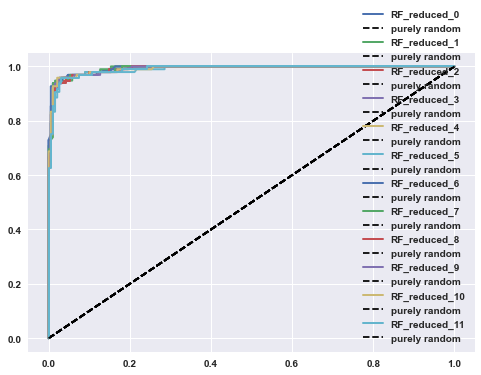

In [207]:
model_name = "RF"
variation = "reduced"

n_estimators = [80, 500]
#max_depth = [4,8,20]
min_samples_split = [2,4,20]
max_features = [int(0.5*num_feats), num_feats-1]

models_rf = []
params = {"n_estimators": None, "max_depth": None, "max_features": None, "min_samples_split": None}
for i,j,k in itertools.product(n_estimators, max_features, min_samples_split):
    print(i,j,k)
    params["n_estimators"]= i
    params["max_features"] = "auto"
    params["min_samples_split"] = j
    params["max_depth"] = k
    models_rf.append(
        (   RFC(n_jobs=-1, bootstrap=True, oob_score=True, n_estimators=i, max_features=int(j), min_samples_split=k, verbose=0),#max_depth=k,
            model_name+"_"+variation, 
            params.copy())
    )
print(f"# {len(models_rf)} different combinations")
cms_rf, res_rf = train_models(models_rf, model_name, variation)   
models_rf_reduced = models_rf

In [210]:
cols_scores = ["accuracy" , "precision", "recall", "f1"]
res_rf

,model,accuracy,precision,recall,f1,traintime
0,RF_reduced_0,0.964912,0.968421,0.937368,0.952642,2.354957
1,RF_reduced_1,0.954386,0.957310,0.937368,0.947234,1.292824
2,RF_reduced_2,0.954386,0.938421,0.937368,0.937894,1.276856
3,RF_reduced_3,0.968421,0.968421,0.958421,0.963395,1.291955
4,RF_reduced_4,0.964912,0.958947,0.947895,0.953389,1.559845
5,RF_reduced_5,0.964912,0.938947,0.947895,0.943400,1.281971
6,RF_reduced_6,0.964912,0.957310,0.937368,0.947234,3.780165
7,RF_reduced_7,0.968421,0.947368,0.937368,0.942342,3.969207
8,RF_reduced_8,0.954386,0.938421,0.937368,0.937894,3.905917
9,RF_reduced_9,0.968421,0.948947,0.947895,0.948421,4.107502


Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\rf\scores_rf_reduced.png>


<Figure size 576x432 with 0 Axes>

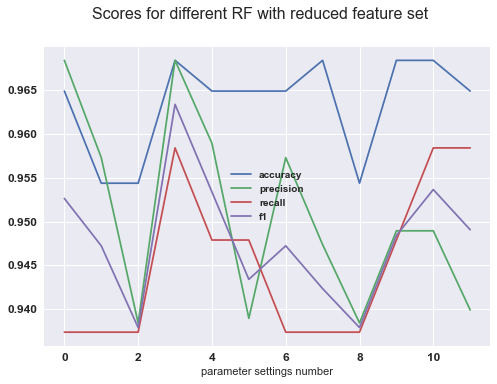

In [211]:
plt.figure(figsize=(8,6))
#plt.rcParams.update({'font.size': 14})
res_rf[cols_scores].plot(fontsize=12)
plt.suptitle("Scores for different RF with reduced feature set", fontsize=16)
plt.xlabel("parameter settings number")
savefig("rf\\scores_rf_reduced.png")

Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\rf\traintimes_rf_reduced.png>


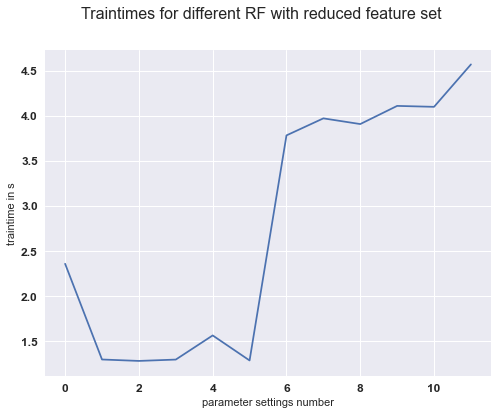

In [212]:
plt.figure(figsize=(8,6))
#plt.rcParams.update({'font.size': 14})
res_rf["traintime"].plot(fontsize=12)
plt.suptitle("Traintimes for different RF with reduced feature set", fontsize=16)
plt.xlabel("parameter settings number")
plt.ylabel("traintime in s")
savefig("rf\\traintimes_rf_reduced.png")

In [127]:
#results_all = results_all.append(res_rf, ignore_index=True)
results_all = res_rf

# 285
Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\confusion_matrices\CM_RF_reduced_0.png>
# 285
Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\confusion_matrices\CM_RF_reduced_1.png>
# 285
Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\confusion_matrices\CM_RF_reduced_2.png>
# 285
Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\confusion_matrices\CM_RF_reduced_3.png>
# 285
Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\confusion_matrices\CM_RF_reduced_4.png>
# 285
Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\confusion_matrices\CM_RF_reduced_5.png>
# 285
Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\confusion_matrices\CM_RF_reduced_6.png>
# 285
Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\confusion_matrices\CM_RF_reduced_7.png>
# 285
Sa

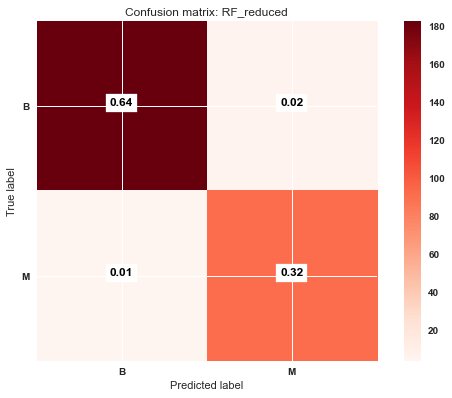

In [213]:
plot_cm_per_model(cms_rf, models_rf_reduced)

80 5 2
80 5 4
80 5 20
80 10 2
80 10 4
80 10 20
500 5 2
500 5 4
500 5 20
500 10 2
500 10 4
500 10 20
# 12 different combinations
params: dict_values([80, 2, 'auto', 5])
params: dict_values([80, 4, 'auto', 5])
params: dict_values([80, 20, 'auto', 5])
params: dict_values([80, 2, 'auto', 10])
params: dict_values([80, 4, 'auto', 10])
params: dict_values([80, 20, 'auto', 10])
params: dict_values([500, 2, 'auto', 5])
params: dict_values([500, 4, 'auto', 5])
params: dict_values([500, 20, 'auto', 5])
params: dict_values([500, 2, 'auto', 10])
params: dict_values([500, 4, 'auto', 10])
params: dict_values([500, 20, 'auto', 10])


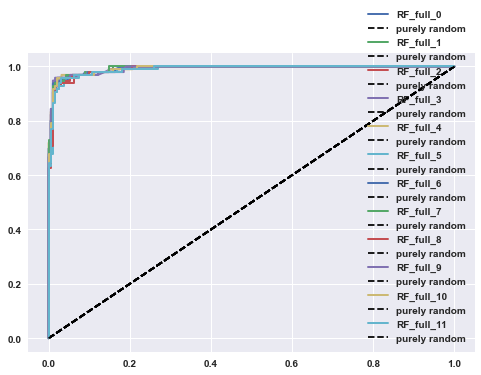

In [214]:
model_name = "RF"
variation = "full"

n_estimators = [80, 500]
#max_depth = [4,8,20]
min_samples_split = [2,4,20]
max_features = [int(0.5*num_feats), num_feats-1]

models_rf = []
params = {"n_estimators": None, "max_depth": None, "max_features": None, "min_samples_split": None}
for i,j,k in itertools.product(n_estimators, max_features, min_samples_split):
    print(i,j,k)
    params["n_estimators"]= i
    params["max_features"] = "auto"
    params["min_samples_split"] = j
    params["max_depth"] = k
    models_rf.append(
        (   RFC(n_jobs=-1, bootstrap=True, oob_score=True, n_estimators=i, max_features=int(j), min_samples_split=k,  verbose=0), #max_depth=k,
            model_name+"_"+variation, 
            params.copy())
    )
print(f"# {len(models_rf)} different combinations")
cms_rf_nodrop, res_rf_nodrop = train_models(models_rf, model_name, variation, x=X_train_nodrop, y=Y_train_nodrop)   
models_rf_nodrop = models_rf

# 285
Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\confusion_matrices\CM_RF_full_0.png>
# 285
Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\confusion_matrices\CM_RF_full_1.png>
# 285
Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\confusion_matrices\CM_RF_full_2.png>
# 285
Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\confusion_matrices\CM_RF_full_3.png>
# 285
Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\confusion_matrices\CM_RF_full_4.png>
# 285
Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\confusion_matrices\CM_RF_full_5.png>
# 285
Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\confusion_matrices\CM_RF_full_6.png>
# 285
Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\confusion_matrices\CM_RF_full_7.png>
# 285
Saving figure at <D:\Studi

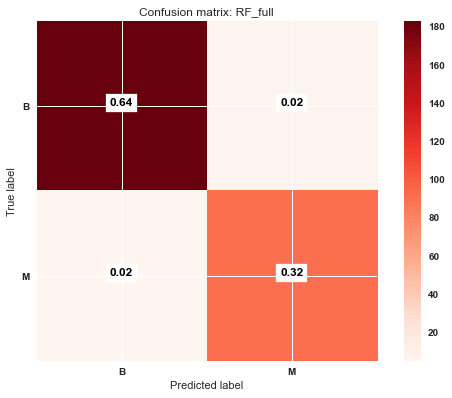

In [215]:
plot_cm_per_model(cms_rf_nodrop, models_rf_nodrop)

In [216]:
res_rf_nodrop

,model,accuracy,precision,recall,f1,traintime
0,RF_full_0,0.964912,0.968421,0.937368,0.952642,2.278426
1,RF_full_1,0.961404,0.957895,0.937368,0.947520,1.606129
2,RF_full_2,0.957895,0.947368,0.937368,0.942342,1.277282
3,RF_full_3,0.971930,0.938947,0.947895,0.943400,1.309624
4,RF_full_4,0.971930,0.959474,0.947895,0.953649,1.248099
5,RF_full_5,0.961404,0.930000,0.958421,0.943997,1.265154
6,RF_full_6,0.968421,0.957310,0.937368,0.947234,3.864139
7,RF_full_7,0.968421,0.947368,0.937368,0.942342,3.940329
8,RF_full_8,0.957895,0.929474,0.937368,0.933404,3.805478
9,RF_full_9,0.971930,0.958947,0.958421,0.958684,4.159167


Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\rf\scores_rf_nodrop.png>


<Figure size 576x432 with 0 Axes>

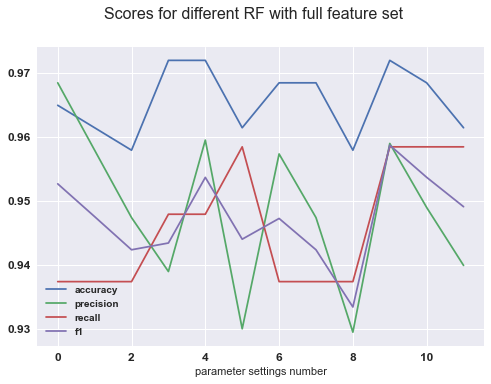

In [217]:
plt.figure(figsize=(8,6))
#plt.rcParams.update({'font.size': 14})
res_rf_nodrop[cols_scores].plot(fontsize=12)
plt.suptitle("Scores for different RF with full feature set", fontsize=16)
plt.xlabel("parameter settings number")
savefig("rf\\scores_rf_nodrop.png")

Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\rf\traintimes_rf_nodrop.png>


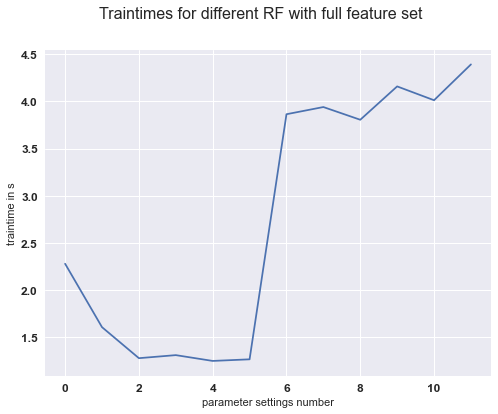

In [218]:
plt.figure(figsize=(8,6))
#plt.rcParams.update({'font.size': 14})
res_rf_nodrop["traintime"].plot(fontsize=12)
plt.suptitle("Traintimes for different RF with full feature set", fontsize=16)
plt.xlabel("parameter settings number")
plt.ylabel("traintime in s")
savefig("rf\\traintimes_rf_nodrop.png")

In [219]:
results_all = results_all.append(res_rf_nodrop, ignore_index=True)
results_all

,model,accuracy,precision,recall,f1,traintime
0,RF_reduced_0,0.957895,0.957310,0.947895,0.952579,1.286651
1,RF_reduced_1,0.961404,0.968421,0.926842,0.947175,1.283914
2,RF_reduced_2,0.954386,0.928947,0.937368,0.933139,1.353829
3,RF_reduced_3,0.968421,0.958947,0.958421,0.958684,1.225881
4,RF_reduced_4,0.964912,0.941148,0.948421,0.944771,1.259315
5,RF_reduced_5,0.957895,0.938947,0.958421,0.948584,1.224897
6,RF_reduced_6,0.964912,0.948421,0.937368,0.942862,3.952819
7,RF_reduced_7,0.964912,0.957310,0.937368,0.947234,3.737518
8,RF_reduced_8,0.961404,0.938421,0.937368,0.937894,3.870224
9,RF_reduced_9,0.968421,0.948947,0.947895,0.948421,3.938720


In [130]:
results_all.iloc[results_all["f1"].idxmax()]

model        RF_reduced_3
accuracy         0.968421
precision        0.958947
recall           0.958421
f1               0.958684
traintime         1.22588
Name: 3, dtype: object

In [131]:
results_all.iloc[results_all["accuracy"].idxmax()]

model        RF_reduced_3
accuracy         0.968421
precision        0.958947
recall           0.958421
f1               0.958684
traintime         1.22588
Name: 3, dtype: object

In [221]:
model_rftest_reduced = models_rf_reduced[3]
model_rftest_reduced

(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features=10,
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
                        oob_score=True, random_state=None, verbose=0,
                        warm_start=False),
 'RF_reduced',
 {'n_estimators': 80,
  'max_depth': 2,
  'max_features': 'auto',
  'min_samples_split': 10})

In [222]:
model_rftest_nodrop = models_rf_nodrop[4]
model_rftest_nodrop

(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features=10,
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=4,
                        min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
                        oob_score=True, random_state=None, verbose=0,
                        warm_start=False),
 'RF_full',
 {'n_estimators': 80,
  'max_depth': 4,
  'max_features': 'auto',
  'min_samples_split': 10})

In [ ]:
cms_rftest_reduced, res_rftest_reduced = train_models(model_rftest_reduced[0], "RF", "reduced", x=X_train, y=Y_train)   
cms_rftest_nodrop, res_rftest_nodrop = train_models(model_rftest_nodrop[0], "RF", "full", x=X_train_nodrop, y=Y_train_nodrop)  

plot_confusion_matrix(cms_rftest_reduced, ["B", "M"], normalize=True, title=f"Confusion matrix: RF on reduced set\n{}", cmap=plt.cm.Reds)

## Note on accuracy

The training data as a whole is split roughly:

B...benign:     66%

M..malignant:   33%

So, if we were to always predict benign, we would already be correct 66% percent of the time! (if predicted on test set)

In [72]:
# Distribution of classes
dist_classes

B    0.663158
M    0.336842
Name: class, dtype: float64

# Multi-Layer-Perceptron

In [73]:
from sklearn.neural_network import MLPClassifier

alphas = [1e-5,1e-4,1e-3,1e-2,1e-1,1]
activation = ["identity","relu","tanh"]
activation = ["relu"]
solver = ["adam"]
h = [11,30,100]
maxiter = 10000

In [74]:
def make_mlp_models(alphas,modes,solv, h,maxiter):
    models_ret = []
    for g in h:
        for i in alphas:
            for j in modes:
                for k in solv:
                    models_ret.append(MLPClassifier(hidden_layer_sizes=(g,g,g), max_iter=maxiter, alpha=i,solver=k,activation=j,tol = 1e-9))
    return models_ret

In [98]:
def MLP_Search(alphas,modes,solv, h,maxiter,X_train, X_valid, Y_train, Y_valid):
    erg = []
    for g in h:
        for i in alphas:
            for j in modes:
                for k in solv:
                    clf = MLPClassifier(hidden_layer_sizes=(g,g), max_iter=maxiter, alpha=i,solver=k,activation=j,tol = 1e-9)
                    traintime = time()
                    clf.fit(X_train, Y_train)
                    traintime = time() - traintime
                    Y_pred = clf.predict(X_valid)
                    print("Hidden layers: ",g,"|\talpha: ",i,"|\tmode: ",j,"|\tsolver: ",k,"|\tscore: ",accuracy_score(Y_valid, Y_pred), "|\ttraintime:", traintime)
                    erg.append({
                        "h": g,
                        "alpha": i,
                        "mode": j,
                        "solver": k,
                        "score": accuracy_score(Y_valid, Y_pred),
                        "traintime": traintime})
        print("")
    return erg

In [76]:
from sklearn.metrics import mean_squared_error
def Statistic(Y_valid,Y_pred,name):
    print("Heat map: ")
    plt.figure()
    cm = confusion_matrix(Y_valid, Y_pred)
    plot_confusion_matrix(cm, ["B", "M"], normalize=True, title=f"Confusion matrix: {name}", cmap=plt.cm.Reds)
    savefig(f"confusion_matrices\\CM_{name}.png")
    #sns.heatmap(cm, center=True)
    #plt.savefig("Heatmap {}".format(name))
    plt.figure()
    sns.distplot(Y_valid)
    sns.distplot(Y_pred, color="red")
    plt.savefig("difference between prediction and validation {}".format(name))

    plt.figure()
    sns.distplot(Y_valid-Y_pred)
    plt.savefig("total difference between prediction and validation {}".format(name))
    print(sqrt(mean_squared_error(Y_valid, Y_pred)))

    Y_pred_Norm = Y_pred / np.linalg.norm(Y_pred)
    Y_valid_Norm = Y_valid / np.linalg.norm(Y_valid)

    print(sqrt(mean_squared_error(Y_pred_Norm, Y_valid_Norm)))
    return cm

In [77]:
def FindBestScore(scores):
    best_score = 0
    best_index = 0
    for i, res in enumerate(scores):
        if res["score"] > best_score:
            best_score = res["score"]
            best_index = i
    print("best_score:", best_score)
    print("best_params:", scores[best_index])
    return scores[best_index]


In [78]:
def plotLC(LC,best_params):
    plt.figure()
    plt.plot(LC)#,label="activation {} Hidden Layers {} solver {} ".format(best_params["alpha"],i,l))
    plt.grid()
    plt.legend()
    plt.xlabel("Iterations")
    plt.xlabel("Loss")
    plt.title("activation {} Hidden Layers {} solver {} ".format(best_params["mode"],best_params["h"],best_params["solver"]))
    plt.savefig("activation {} Hidden Layers {} solver {} ".format(best_params["mode"],best_params["h"],best_params["solver"]))


In [79]:
alphas = [1e-5,1e-1,1]
activations = ["identity","relu"]
#activation = ["relu"]
solver = ["adam"]
h = [11,30,100]
maxiter = 10000

11 1e-05 identity
11 1e-05 relu
11 0.1 identity
11 0.1 relu
11 1 identity
11 1 relu
30 1e-05 identity
30 1e-05 relu
30 0.1 identity
30 0.1 relu
30 1 identity
30 1 relu
100 1e-05 identity
100 1e-05 relu
100 0.1 identity
100 0.1 relu
100 1 identity
100 1 relu
# 18 different combinations
params: dict_values([None, 11, None, 'auto', 1e-05, 'identity'])
params: dict_values([None, 11, None, 'auto', 1e-05, 'relu'])
params: dict_values([None, 11, None, 'auto', 0.1, 'identity'])
params: dict_values([None, 11, None, 'auto', 0.1, 'relu'])
params: dict_values([None, 11, None, 'auto', 1, 'identity'])
params: dict_values([None, 11, None, 'auto', 1, 'relu'])
params: dict_values([None, 30, None, 'auto', 1e-05, 'identity'])
params: dict_values([None, 30, None, 'auto', 1e-05, 'relu'])
params: dict_values([None, 30, None, 'auto', 0.1, 'identity'])
params: dict_values([None, 30, None, 'auto', 0.1, 'relu'])
params: dict_values([None, 30, None, 'auto', 1, 'identity'])
params: dict_values([None, 30, None, 'a

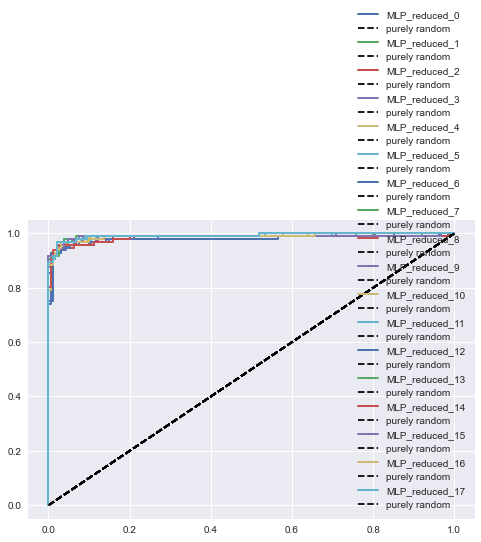

params: dict_values([None, 11, None, 'auto', 1e-05, 'identity'])
params: dict_values([None, 11, None, 'auto', 1e-05, 'relu'])
params: dict_values([None, 11, None, 'auto', 0.1, 'identity'])


C:\Dev\Python3.7\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Dev\Python3.7\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Dev\Python3.7\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Dev\Python3.7\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Dev\P

params: dict_values([None, 11, None, 'auto', 0.1, 'relu'])


C:\Dev\Python3.7\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Dev\Python3.7\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Dev\Python3.7\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Dev\Python3.7\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Dev\P

params: dict_values([None, 11, None, 'auto', 1, 'identity'])
params: dict_values([None, 11, None, 'auto', 1, 'relu'])


C:\Dev\Python3.7\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Dev\Python3.7\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Dev\Python3.7\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Dev\Python3.7\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Dev\P

params: dict_values([None, 30, None, 'auto', 1e-05, 'identity'])
params: dict_values([None, 30, None, 'auto', 1e-05, 'relu'])
params: dict_values([None, 30, None, 'auto', 0.1, 'identity'])
params: dict_values([None, 30, None, 'auto', 0.1, 'relu'])


C:\Dev\Python3.7\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Dev\Python3.7\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Dev\Python3.7\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Dev\Python3.7\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Dev\P

params: dict_values([None, 30, None, 'auto', 1, 'identity'])
params: dict_values([None, 30, None, 'auto', 1, 'relu'])
params: dict_values([None, 100, None, 'auto', 1e-05, 'identity'])
params: dict_values([None, 100, None, 'auto', 1e-05, 'relu'])
params: dict_values([None, 100, None, 'auto', 0.1, 'identity'])
params: dict_values([None, 100, None, 'auto', 0.1, 'relu'])
params: dict_values([None, 100, None, 'auto', 1, 'identity'])
params: dict_values([None, 100, None, 'auto', 1, 'relu'])


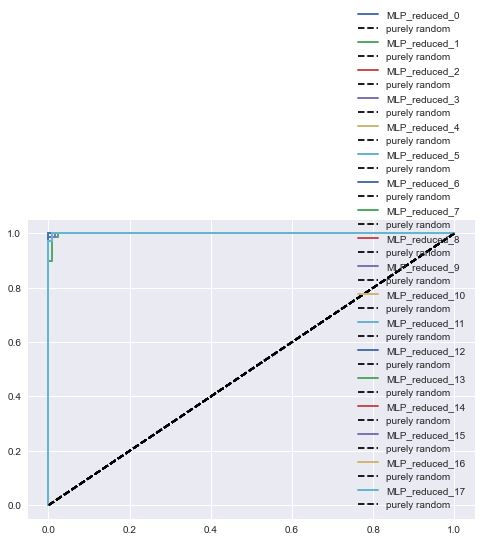

In [133]:
model_name = "MLP"
variation = "reduced"

models_mlp = []
params = {"h": None, "alphas": None, "activations": None}
for i,j,k in itertools.product(h, alphas, activations):
    print(i,j,k)
    params["alphas"]= i
    params["activation"] = "auto"
    params["min_samples_split"] = j
    params["max_depth"] = k
    models_mlp.append(
        (MLPClassifier(hidden_layer_sizes=(i,i), max_iter=maxiter, alpha=j,solver="adam",activation=k,tol = 1e-9),
         model_name+"_"+variation, 
         params.copy())
    )
print(f"# {len(models_mlp)} different combinations")

cms_mlp, res_mlp = train_models(models_mlp, model_name, variation, x=X_train, y=Y_train)   
models_mlp_reduced = models_mlp

cms_mlp_nodrop, res_mlp_nodrop = train_models(models_mlp, model_name, variation, x=X_train_nodrop, y=Y_train_nodrop)   
models_mlp_full = models_mlp

In [135]:
res_mlp

,model,accuracy,precision,recall,f1,traintime
0,MLP_reduced_0,0.961404,0.958947,0.927368,0.942894,1.990485
1,MLP_reduced_1,0.961404,0.957895,0.937895,0.947789,39.415780
2,MLP_reduced_2,0.964912,0.958947,0.927368,0.942894,1.840101
3,MLP_reduced_3,0.964912,0.969474,0.927368,0.947954,6.695093
4,MLP_reduced_4,0.961404,0.969474,0.916842,0.942424,2.426220
5,MLP_reduced_5,0.964912,0.968421,0.916842,0.941926,3.687663
6,MLP_reduced_6,0.964912,0.969474,0.927368,0.947954,1.597387
7,MLP_reduced_7,0.961404,0.968421,0.916842,0.941926,37.435909
8,MLP_reduced_8,0.964912,0.958947,0.927368,0.942894,1.397223
9,MLP_reduced_9,0.968421,0.968421,0.927368,0.947450,6.646285


Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\rf\scores_mlp_reduced.png>


<Figure size 576x432 with 0 Axes>

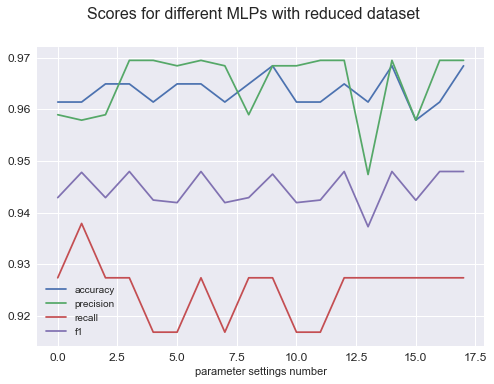

In [161]:
plt.figure(figsize=(8,6))
#plt.rcParams.update({'font.size': 14})
res_mlp[cols_scores].plot(fontsize=12)
plt.suptitle("Scores for different MLPs with reduced feature set", fontsize=16)
plt.xlabel("parameter settings number")
savefig("mlp\\scores_mlp_reduced.png")

Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\rf\traintimes_mlp_reduced.png>


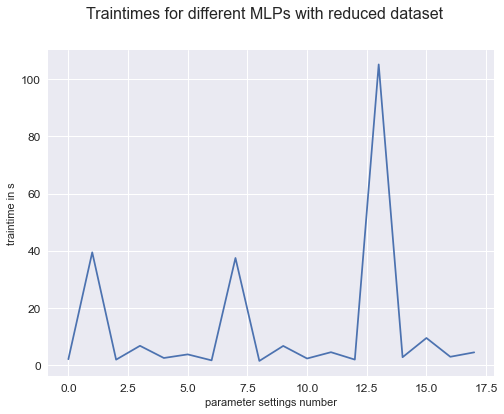

In [162]:
plt.figure(figsize=(8,6))
#plt.rcParams.update({'font.size': 14})
res_mlp["traintime"].plot(fontsize=12)
plt.suptitle("Traintimes for different MLPs with reduced feature set", fontsize=16)
plt.xlabel("parameter settings number")
plt.ylabel("traintime in s")
savefig("mlp\\traintimes_mlp_reduced.png")

In [134]:
res_mlp_nodrop

,model,accuracy,precision,recall,f1,traintime
0,MLP_reduced_0,0.995000,1.000000,0.985714,0.992806,20.232540
1,MLP_reduced_1,0.990000,0.973333,0.957143,0.965170,27.548208
2,MLP_reduced_2,0.984872,1.000000,0.957143,0.978102,21.011461
3,MLP_reduced_3,0.979872,1.000000,0.942857,0.970588,32.588915
4,MLP_reduced_4,0.984872,1.000000,0.957143,0.978102,11.161072
5,MLP_reduced_5,0.984872,1.000000,0.957143,0.978102,31.544514
6,MLP_reduced_6,0.989872,1.000000,0.971429,0.985507,19.017293
7,MLP_reduced_7,0.969744,0.986667,0.971429,0.978988,26.632509
8,MLP_reduced_8,0.984872,1.000000,0.957143,0.978102,23.586774
9,MLP_reduced_9,0.979872,1.000000,0.942857,0.970588,43.784345


Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\mlp\scores_mlp_nodrop.png>


<Figure size 576x432 with 0 Axes>

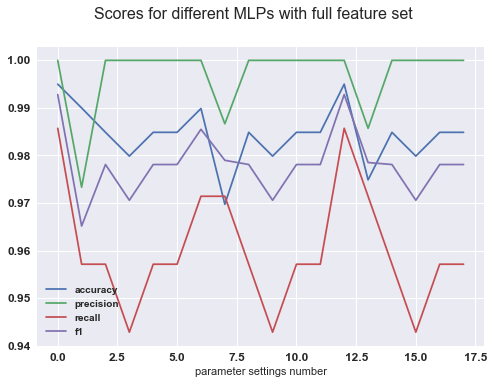

In [233]:
plt.figure(figsize=(8,6))
#plt.rcParams.update({'font.size': 14})
res_mlp_nodrop[cols_scores].plot(fontsize=12)
plt.suptitle("Scores for different MLPs with full feature set", fontsize=16)
plt.xlabel("parameter settings number")
savefig("mlp\\scores_mlp_nodrop.png")

Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\mlp\traintimes_mlp_nodrop.png>


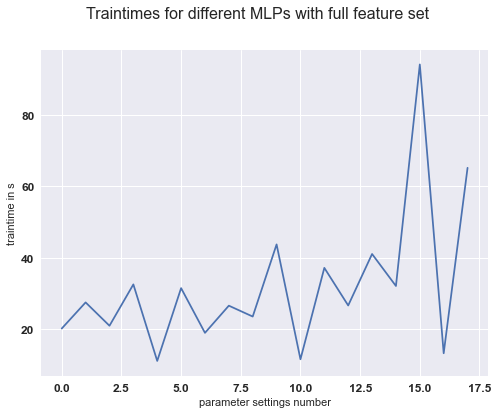

In [234]:
plt.figure(figsize=(8,6))
#plt.rcParams.update({'font.size': 14})
res_mlp_nodrop["traintime"].plot(fontsize=12)
plt.suptitle("Traintimes for different MLPs with full feature set", fontsize=16)
plt.xlabel("parameter settings number")
plt.ylabel("traintime in s")
savefig("mlp\\traintimes_mlp_nodrop.png")

In [ ]:
results_all = results_all.append(res_mlp, ignore_index=True)
results_all

In [82]:
train, valid = train_test_split(df, test_size=.3) # We don't have that many samples...30% test seems reasonable#
X_train = train[cols["features"]]
Y_train = train[cols["class"]]
X_valid = valid[cols["features"]]
Y_valid = valid[cols["class"]]
print("# of unique values in Y_train: ", Y_train.nunique())
print("# of unique values in Y_train: ", Y_train.nunique())
Y_train

# of unique values in Y_train:  2
# of unique values in Y_train:  2


196    0
137    0
200    0
208    0
129    0
      ..
228    1
120    0
269    0
74     0
105    0
Name: class, Length: 199, dtype: int64

In [83]:
train_nodrop, valid_nodrop = train_test_split(df_nodrop, test_size=.3) # We don't have that many samples...30% test seems reasonable#
X_train_nodrop = train_nodrop[cols_nodrop["features"]]
Y_train_nodrop = train_nodrop[cols_nodrop["class"]]
X_valid_nodrop = valid_nodrop[cols_nodrop["features"]]
Y_valid_nodrop = valid_nodrop[cols_nodrop["class"]]
print("# of unique values in Y_train: ", Y_train.nunique())
print("# of unique values in Y_train: ", Y_train.nunique())
Y_train

# of unique values in Y_train:  2
# of unique values in Y_train:  2


196    0
137    0
200    0
208    0
129    0
      ..
228    1
120    0
269    0
74     0
105    0
Name: class, Length: 199, dtype: int64

In [99]:
scores = MLP_Search(alphas,activation,solver,h,maxiter, X_train, X_valid, Y_train, Y_valid)
best_params_BMG_N = FindBestScore(scores)

scores = MLP_Search(alphas,activation,solver,h,maxiter,X_train_nodrop, X_valid_nodrop, Y_train_nodrop, Y_valid_nodrop)
best_params_GB_N = FindBestScore(scores)

Hidden layers:  11 |	alpha:  1e-05 |	mode:  relu |	solver:  adam |	score:  0.9767441860465116 |	traintime: 8.98011565208435
Hidden layers:  11 |	alpha:  0.1 |	mode:  relu |	solver:  adam |	score:  0.9651162790697675 |	traintime: 6.991641521453857
Hidden layers:  11 |	alpha:  1 |	mode:  relu |	solver:  adam |	score:  0.9651162790697675 |	traintime: 3.8078527450561523

Hidden layers:  30 |	alpha:  1e-05 |	mode:  relu |	solver:  adam |	score:  0.9767441860465116 |	traintime: 8.379438638687134
Hidden layers:  30 |	alpha:  0.1 |	mode:  relu |	solver:  adam |	score:  0.9651162790697675 |	traintime: 8.335071325302124
Hidden layers:  30 |	alpha:  1 |	mode:  relu |	solver:  adam |	score:  0.9534883720930233 |	traintime: 5.248916149139404

Hidden layers:  100 |	alpha:  1e-05 |	mode:  relu |	solver:  adam |	score:  0.9767441860465116 |	traintime: 14.422670602798462
Hidden layers:  100 |	alpha:  0.1 |	mode:  relu |	solver:  adam |	score:  0.9651162790697675 |	traintime: 18.252343893051147
Hidden l

C:\Dev\Python3.7\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Hidden layers:  11 |	alpha:  0.1 |	mode:  relu |	solver:  adam |	score:  0.9883720930232558 |	traintime: 7.34732723236084


C:\Dev\Python3.7\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Hidden layers:  11 |	alpha:  1 |	mode:  relu |	solver:  adam |	score:  0.9767441860465116 |	traintime: 7.778365850448608

Hidden layers:  30 |	alpha:  1e-05 |	mode:  relu |	solver:  adam |	score:  0.9883720930232558 |	traintime: 5.844122886657715
Hidden layers:  30 |	alpha:  0.1 |	mode:  relu |	solver:  adam |	score:  0.9767441860465116 |	traintime: 8.784101009368896
Hidden layers:  30 |	alpha:  1 |	mode:  relu |	solver:  adam |	score:  0.9767441860465116 |	traintime: 7.89914345741272

Hidden layers:  100 |	alpha:  1e-05 |	mode:  relu |	solver:  adam |	score:  0.9651162790697675 |	traintime: 9.863963603973389
Hidden layers:  100 |	alpha:  0.1 |	mode:  relu |	solver:  adam |	score:  0.9767441860465116 |	traintime: 19.97771167755127
Hidden layers:  100 |	alpha:  1 |	mode:  relu |	solver:  adam |	score:  0.9767441860465116 |	traintime: 12.011046886444092

best_score: 0.9883720930232558
best_params: {'h': 11, 'alpha': 0.1, 'mode': 'relu', 'solver': 'adam', 'score': 0.9883720930232558, 'tra

In [85]:
best_params_reduced = {'h': 11, 'alpha': 1e-05, 'mode': 'relu', 'solver': 'adam', 'score': 0.9767441860465116, 'traintime': 8.98011565208435}
best_params_nodrop = {'h': 11, 'alpha': 0.1, 'mode': 'relu', 'solver': 'adam', 'score': 0.9883720930232558, 'traintime': 7.34732723236084}

In [86]:
from math import sqrt

C:\Dev\Python3.7\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Heat map: 
# 86
Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\confusion_matrices\CM_MLP_reduced.png>


No handles with labels found to put in legend.


0.1867718419094071
0.03289780184725986
Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\>


C:\Dev\Python3.7\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Heat map: 
# 86
Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\confusion_matrices\CM_MLP_nodrop.png>


No handles with labels found to put in legend.


0.1867718419094071
0.03515277191491955


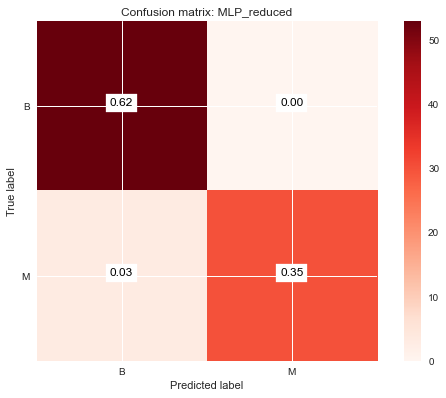

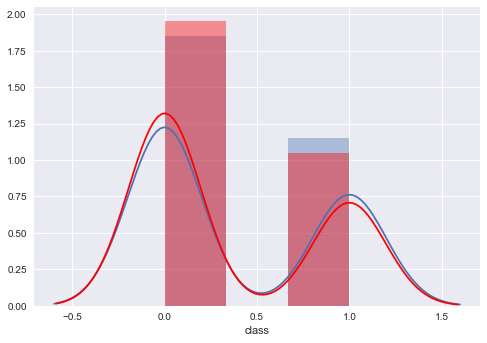

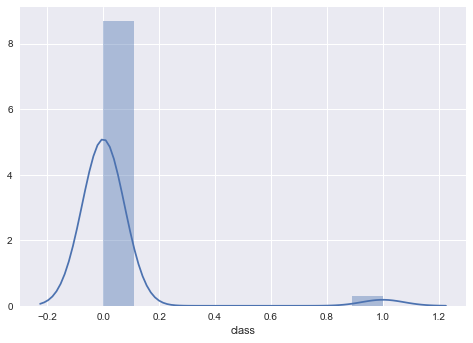

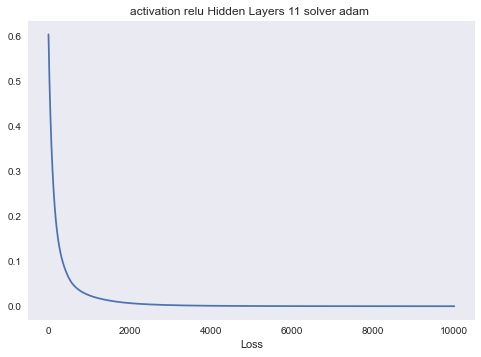

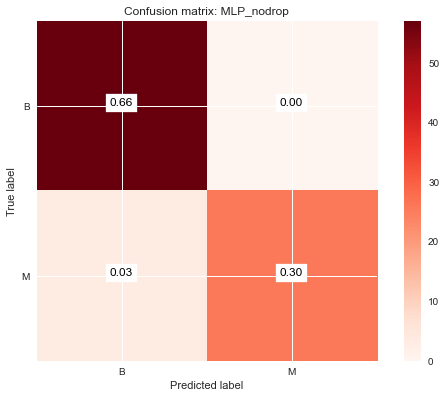

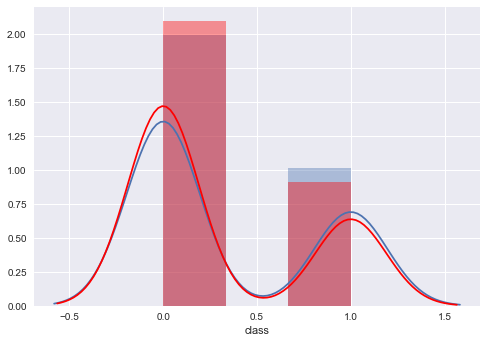

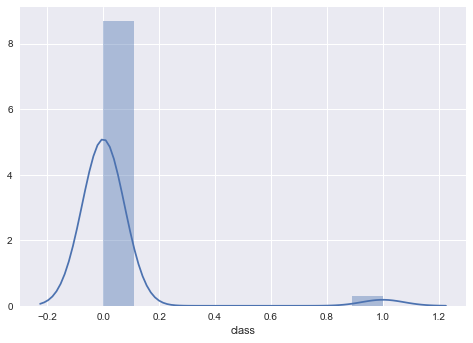

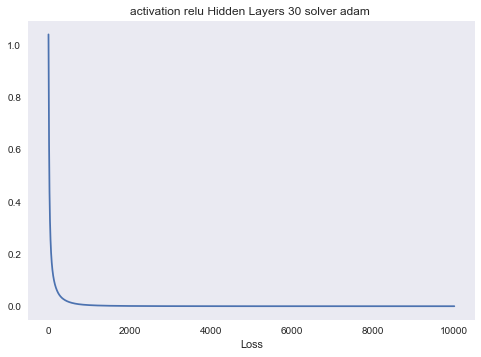

In [87]:
models_mlp_selection = []
clf = MLPClassifier(hidden_layer_sizes=(best_params_BMG_N["h"]), max_iter=10000, alpha=best_params_BMG_N["alpha"],solver=best_params_BMG_N["solver"],activation=best_params_BMG_N["mode"],tol=1e-9,verbose=False)
clf.fit(X_train, Y_train)
Y_pred_BMG_N = clf.predict(X_valid)
LC = clf.loss_curve_
cm = Statistic(Y_valid,Y_pred_BMG_N,"MLP_reduced")
savefig("")
plotLC(LC,best_params_BMG_N)
models_mlp_selection.append((clf, cm, best_params_BMG_N))


clf = MLPClassifier(hidden_layer_sizes=(best_params_GB_N["h"]), max_iter=10000, alpha=best_params_GB_N["alpha"],solver=best_params_GB_N["solver"],activation=best_params_GB_N["mode"],tol=1e-9,verbose=False)
clf.fit(X_train_nodrop, Y_train_nodrop)
LC = clf.loss_curve_
Y_pred_GB_N = clf.predict(X_valid_nodrop)
cm = Statistic(Y_valid_nodrop,Y_pred_GB_N,"MLP_nodrop")
plotLC(LC,best_params_GB_N)
models_mlp_selection.append((clf, cm, best_params_GB_N))

# kNN

Note: Should use scaled features here

Expectation: should work well for this task!
After all, this technique has been widely used for CT-scans for years.

In [100]:
train, valid = train_test_split(df, test_size=.3) # We don't have that many samples...30% test seems reasonable#
X_train = train[cols["features"]]
Y_train = train[cols["class"]]
X_valid = valid[cols["features"]]
Y_valid = valid[cols["class"]]
print("# of unique values in Y_train: ", Y_train.nunique())
Y_train
train_nodrop, valid_nodrop = train_test_split(df_nodrop, test_size=.3) # We don't have that many samples...30% test seems reasonable#
X_train_nodrop = train_nodrop[cols_nodrop["features"]]
Y_train_nodrop = train_nodrop[cols_nodrop["class"]]
X_valid_nodrop = valid_nodrop[cols_nodrop["features"]]
Y_valid_nodrop = valid_nodrop[cols_nodrop["class"]]
print("# of unique values in Y_train: ", Y_train.nunique())
Y_train

# of unique values in Y_train:  2
# of unique values in Y_train:  2


284    0
87     0
126    0
56     1
176    0
      ..
174    1
236    1
78     1
186    0
208    0
Name: class, Length: 199, dtype: int64

In [105]:
X_train = df[cols["features"]]
Y_train = df[cols["class"]]
X_train

,radiusMean,textureMean,compactnessMean,concavityMean,concavePointsMean,radiusStdErr,compactnessStdErr,concavePointsStdErr,compactnessWorst,concavityWorst,concavePointsWorst
0,-0.747815,-0.917988,-0.684283,-0.677338,-0.505998,-0.981918,-0.606683,-0.541445,-0.559757,-0.625066,-0.432503
1,0.983244,-0.053862,1.145409,1.443253,1.799579,-0.408980,-0.326410,0.266467,0.948905,1.176435,2.237070
2,-1.012710,0.213104,1.327736,1.946310,0.374862,-1.289394,2.916579,2.634060,0.741019,1.680198,0.539653
3,-0.199544,1.391033,-1.033190,-0.776726,-0.737848,-0.826747,-1.016905,-0.873216,-0.945832,-0.629546,-0.821587
4,1.177296,0.334878,1.338095,1.368474,1.696152,2.051787,1.369037,0.971346,0.661164,0.462107,0.618383
...,...,...,...,...,...,...,...,...,...,...,...
280,-0.633849,-0.639313,1.410611,1.101989,0.798341,-0.295348,0.608791,0.974431,1.053179,0.920571,1.169492
281,-0.911064,-1.487047,-1.341281,-1.111599,-1.142711,-0.476300,-1.129014,-1.316658,-1.099998,-1.229183,-1.144694
282,-0.039374,0.772796,2.639246,1.739649,0.973594,-0.809082,1.934187,0.642814,3.450804,2.134680,1.709579
283,-0.048615,-0.391082,-0.463004,-0.535258,-0.424118,-0.661073,-1.010920,-0.444119,-0.759064,-0.454324,-0.337870


In [106]:
def find_best_score(metrics, target="accuracy"):
    best_target = 0
    best_index = 0
    for idx, met in enumerate(metrics):
        if met[target] > best_target:
            best_target = met[target]
            best_index = idx
    return best_target, metrics[best_index], best_index

In [125]:
results_all

,model,accuracy,precision,recall,f1,traintime


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 24, 28, 32, 36, 40, 44, 48]
Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\knn\scores_knn_uniform_reduced>


<Figure size 576x396 with 0 Axes>

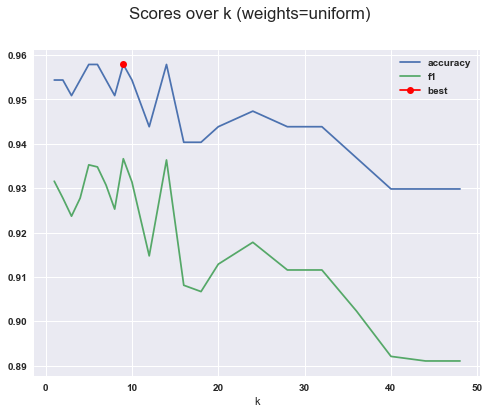

Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\knn\traintimes_knn_uniform_reduced>


<Figure size 576x396 with 0 Axes>

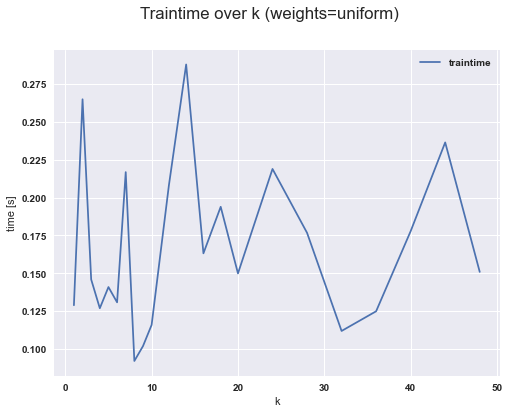

Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\knn\scores_knn_distance_reduced>


<Figure size 576x396 with 0 Axes>

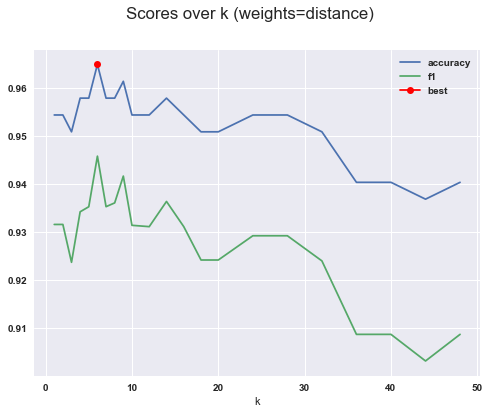

Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\knn\traintimes_knn_distance_reduced>


<Figure size 576x396 with 0 Axes>

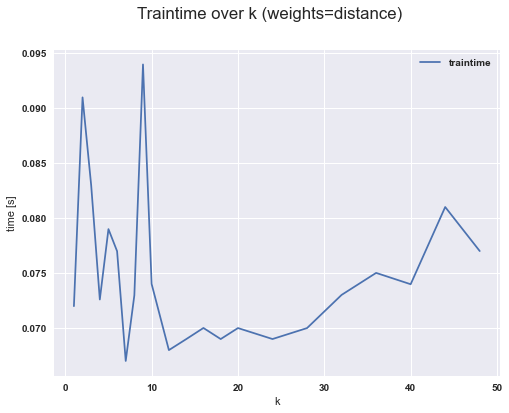

In [201]:
# KNN Test
from sklearn.neighbors import KNeighborsClassifier
var = "reduced"

ks = list(range(1, 10)) + list(range(10, 20, 2)) + list(range(20, 51, 4))
print(ks)
weights = ["uniform", "distance"]
metrics = []
for weight in weights:
    scores = []
    mets = []
    best_ks = []
    best_k = 0
    best_score = 0
    for k in ks:
        knn = KNeighborsClassifier(n_neighbors=k, weights=weight)
        #knn.fit(X_train, Y_train)
        #Y_pred = knn.predict(X_valid)
        #score = accuracy_score(Y_valid, Y_pred)
        traintime = time()
        metric = cross_val_metrics(knn, X_train, Y_train, cv=5, show=False)
        traintime = time() - traintime
        metric["traintime"] = traintime
        metric["model"] = f"{weights}_{k}_{var}"
        mets.append(metric)
        score = metric["accuracy"]
        scores.append(score)
        #best_score = max(scores)
        if score > best_score:
            best_k = k
            best_score= score
        score
    metrics.append(mets)
    best_score
    best_ks
    plt.clf()
    plt.figure(figsize=(8,6))
    plt.suptitle(f"Scores over k (weights={weight})")
    plt.plot(ks, scores, label="accuracy")
    plt.plot(ks, [met["f1"] for met in mets], label="f1")
    plt.plot(best_k, best_score, marker="o", color="red", label="best")
    plt.xlabel("k")
    plt.legend()
    savefig(f"knn\\scores_knn_{weight}_reduced")
    plt.show()
    plt.clf()
    plt.figure(figsize=(8,6))
    plt.suptitle(f"Traintime over k (weights={weight})")
    plt.plot(ks, [met["traintime"] for met in mets], label="traintime")
    plt.ylabel("time [s]")
    plt.xlabel("k")
    plt.legend()
    savefig(f"knn\\traintimes_knn_{weight}_reduced")
    plt.show()
metrics_knn_reduced = metrics.copy()

In [199]:
results_knn_reduced = pd.DataFrame(metrics_knn_reduced[0], columns=results_all.columns)
results_knn_reduced

,model,accuracy,precision,recall,f1,traintime
0,"['uniform', 'distance']_1_reduced",0.954386,0.946784,0.916842,0.931572,0.096934
1,"['uniform', 'distance']_2_reduced",0.954386,1.000000,0.865263,0.927765,0.094946
2,"['uniform', 'distance']_3_reduced",0.950877,0.977124,0.875789,0.923686,0.092961
3,"['uniform', 'distance']_4_reduced",0.954386,1.000000,0.865263,0.927765,0.087945
4,"['uniform', 'distance']_5_reduced",0.957895,0.977124,0.896842,0.935263,0.087955
5,"['uniform', 'distance']_6_reduced",0.957895,0.988889,0.886316,0.934797,0.086936
6,"['uniform', 'distance']_7_reduced",0.954386,0.967836,0.896316,0.930704,0.094955
7,"['uniform', 'distance']_8_reduced",0.950877,0.967836,0.886316,0.925284,0.101932
8,"['uniform', 'distance']_9_reduced",0.957895,0.957310,0.916842,0.936639,0.089980
9,"['uniform', 'distance']_10_reduced",0.954386,0.957310,0.906842,0.931393,0.087551


In [115]:
targets = ["accuracy", "f1"]
k_selection = {"uniform": {"accuracy": None, "f1": None}, "distance": {"accuracy": None, "f1": None}}
for weight, metric_list in zip(weights, metrics):
    for target in targets:
        print(f"weights={weight} sorted by {target}")
        sel = find_best_score(metric_list, target=target)
        print(sel)
        k_selection[weight][target] = sel[2]
    print()

weights=uniform sorted by accuracy
(0.9578947368421054, {'accuracy': 0.9578947368421054, 'precision': 0.9573099415204677, 'recall': 0.9168421052631579, 'f1': 0.9366391202669679, 'traintime': 0.10492801666259766}, 8)
weights=uniform sorted by f1
(0.9366391202669679, {'accuracy': 0.9578947368421054, 'precision': 0.9573099415204677, 'recall': 0.9168421052631579, 'f1': 0.9366391202669679, 'traintime': 0.10492801666259766}, 8)

weights=distance sorted by accuracy
(0.9649122807017543, {'accuracy': 0.9649122807017543, 'precision': 0.9888888888888889, 'recall': 0.9063157894736843, 'f1': 0.9458035053073315, 'traintime': 0.06195950508117676}, 5)
weights=distance sorted by f1
(0.9458035053073315, {'accuracy': 0.9649122807017543, 'precision': 0.9888888888888889, 'recall': 0.9063157894736843, 'f1': 0.9458035053073315, 'traintime': 0.06195950508117676}, 5)



# 285
Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\confusion_matrices\CM_knn5_distance.png>
Accuracy  =     1.000
Precision =     1.000
Recall    =     1.000
F1_score  =     1.000


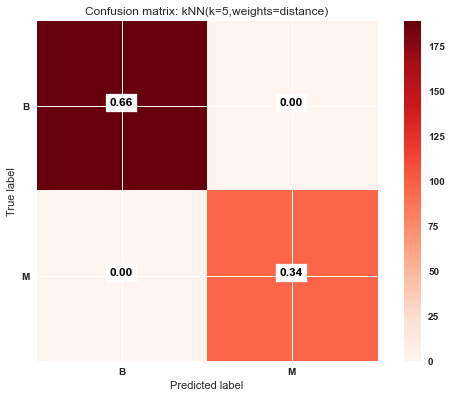

# 285
Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\confusion_matrices\CM_knn8_uniform.png>
Accuracy  =     0.972
Precision =     1.000
Recall    =     0.917
F1_score  =     0.957


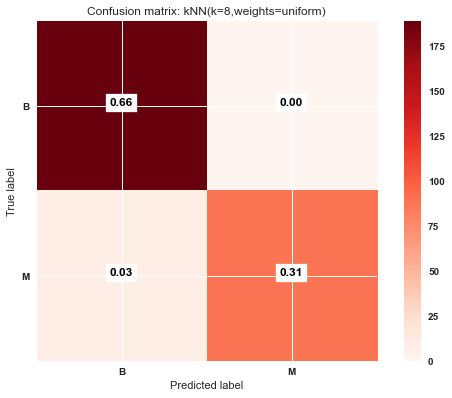

In [230]:
params5 = {"k": 5, "weights":"distance"}
knn5 = KNeighborsClassifier(n_neighbors=params5["k"], weights=params5["weights"])
knn5.fit(X_train, Y_train)
Y_pred = knn5.predict(X_train)
score_knn5 = accuracy_score(Y_train, Y_pred)
cm_knn5 = confusion_matrix(Y_train, Y_pred)
plot_confusion_matrix(cm_knn5,  ["B", "M"],
                          normalize = True,
                          title = 'Confusion matrix: kNN(k=5,weights=distance)',
                          cmap = plt.cm.Reds)
savefig("confusion_matrices\\CM_knn5_distance.png")
metrics_knn = show_metrics(cm_knn5)
plt.show()

params8 = {"k": 8, "weights":"uniform"}
knn8 = KNeighborsClassifier(n_neighbors=params8["k"], weights=params8["weights"])
knn8.fit(X_train, Y_train)
Y_pred = knn8.predict(X_train)
score_knn8 = accuracy_score(Y_train, Y_pred)
cm_knn8 = confusion_matrix(Y_train, Y_pred)
plot_confusion_matrix(cm_knn8,  ["B", "M"],
                          normalize = True,
                          title = 'Confusion matrix: kNN(k=8,weights=uniform)',
                          cmap = plt.cm.Reds)
savefig("confusion_matrices\\CM_knn8_uniform.png")
metrics_knn = show_metrics(cm_knn8)
plt.show()

models_knn_selection_reduced = [(knn5, cm_knn5, params5.copy()), (knn8, cm_knn8, params8.copy())]

## on full dataset

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 24, 28, 32, 36, 40, 44, 48]
Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\knn\scores_knn_uniform_nodrop>


<Figure size 576x396 with 0 Axes>

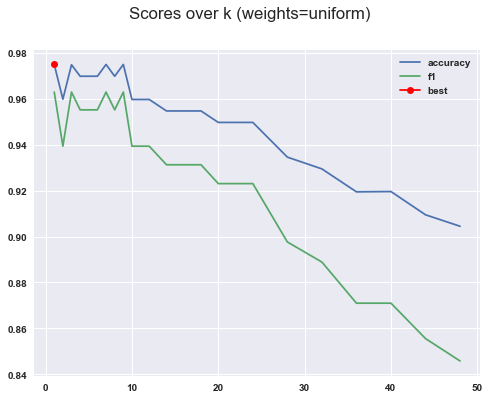

Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\knn\traintimes_knn_uniform_nodrop>


<Figure size 576x396 with 0 Axes>

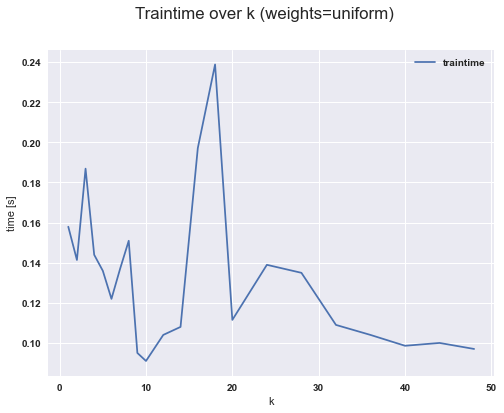

Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\knn\scores_knn_distance_nodrop>


<Figure size 576x396 with 0 Axes>

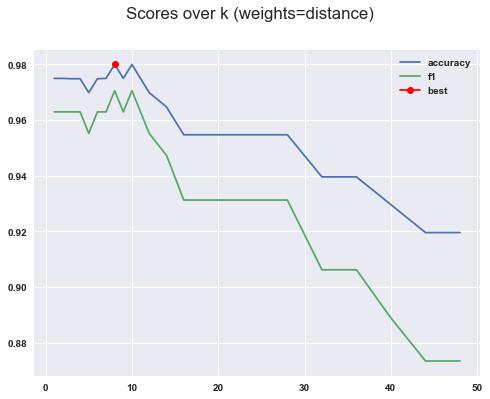

Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\knn\traintimes_knn_distance_nodrop>


<Figure size 576x396 with 0 Axes>

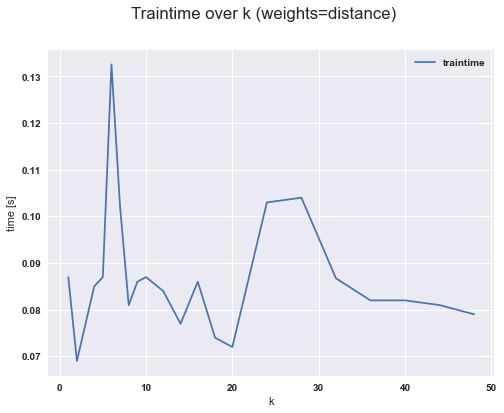

In [202]:
var = "nodrop"

ks = list(range(1, 10)) + list(range(10, 20, 2)) + list(range(20, 51, 4))
print(ks)
weights = ["uniform", "distance"]
metrics = []
for weight in weights:
    scores = []
    mets = []
    best_ks = []
    best_k = 0
    best_score = 0
    for k in ks:
        knn = KNeighborsClassifier(n_neighbors=k, weights=weight)
        #knn.fit(X_train, Y_train)
        #Y_pred = knn.predict(X_valid)
        #score = accuracy_score(Y_valid, Y_pred)
        traintime = time()
        metric = cross_val_metrics(knn, X_train_nodrop, Y_train_nodrop, cv=5, show=False)
        traintime = time() - traintime
        metric["traintime"] = traintime
        metric["model"] = f"{weights}_{k}_{var}"
        mets.append(metric)
        score = metric["accuracy"]
        scores.append(score)
        #best_score = max(scores)
        if score > best_score:
            best_k = k
            best_score= score
        score
    metrics.append(mets)
    best_score
    best_ks
    plt.clf()
    plt.figure(figsize=(8,6))
    plt.suptitle(f"Scores over k (weights={weight})")
    plt.plot(ks, scores, label="accuracy")
    plt.plot(ks, [met["f1"] for met in mets], label="f1")
    plt.plot(best_k, best_score, marker="o", color="red", label="best")
    plt.legend()
    savefig(f"knn\\scores_knn_{weight}_nodrop")
    plt.show()
    plt.clf()
    plt.figure(figsize=(8,6))
    plt.suptitle(f"Traintime over k (weights={weight})")
    plt.plot(ks, [met["traintime"] for met in mets], label="traintime")
    plt.ylabel("time [s]")
    plt.xlabel("k")
    plt.legend()
    savefig(f"knn\\traintimes_knn_{weight}_nodrop")
    plt.show()
metrics_knn_nodrop = metrics.copy()

In [123]:
metrics_knn_nodrop

[[{'accuracy': 0.975,
   'precision': 1.0,
   'recall': 0.9285714285714286,
   'f1': 0.962962962962963,
   'traintime': 0.0930018424987793},
  {'accuracy': 0.9598717948717947,
   'precision': 1.0,
   'recall': 0.8857142857142858,
   'f1': 0.9393939393939394,
   'traintime': 0.08699679374694824},
  {'accuracy': 0.9748717948717948,
   'precision': 1.0,
   'recall': 0.9285714285714286,
   'f1': 0.962962962962963,
   'traintime': 0.08696436882019043},
  {'accuracy': 0.9698717948717949,
   'precision': 1.0,
   'recall': 0.9142857142857144,
   'f1': 0.955223880597015,
   'traintime': 0.08201122283935547},
  {'accuracy': 0.9698717948717949,
   'precision': 1.0,
   'recall': 0.9142857142857144,
   'f1': 0.955223880597015,
   'traintime': 0.0840158462524414},
  {'accuracy': 0.9698717948717949,
   'precision': 1.0,
   'recall': 0.9142857142857144,
   'f1': 0.955223880597015,
   'traintime': 0.08194398880004883},
  {'accuracy': 0.975,
   'precision': 1.0,
   'recall': 0.9285714285714286,
   'f1':

In [95]:
targets = ["accuracy", "f1"]
k_selection = {"uniform": {"accuracy": None, "f1": None}, "distance": {"accuracy": None, "f1": None}}
for weight, metric_list in zip(weights, metrics):
    for target in targets:
        print(f"weights={weight} sorted by {target}")
        sel = find_best_score(metric_list, target=target)
        print(sel)
        k_selection[weight][target] = sel[2]
    print()

weights=uniform sorted by accuracy
(0.9697435897435897, {'accuracy': 0.9697435897435897, 'precision': 1.0, 'recall': 0.9076923076923077, 'f1': 0.9516129032258065}, 4)
weights=uniform sorted by f1
(0.9516129032258065, {'accuracy': 0.9697435897435897, 'precision': 1.0, 'recall': 0.9076923076923077, 'f1': 0.9516129032258065}, 4)

weights=distance sorted by accuracy
(0.9697435897435897, {'accuracy': 0.9697435897435897, 'precision': 1.0, 'recall': 0.9076923076923077, 'f1': 0.9516129032258065}, 4)
weights=distance sorted by f1
(0.9516129032258065, {'accuracy': 0.9697435897435897, 'precision': 1.0, 'recall': 0.9076923076923077, 'f1': 0.9516129032258065}, 4)



# 199
Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\confusion_matrices\CM_knn5_distance.png>
Accuracy  =     1.000
Precision =     1.000
Recall    =     1.000
F1_score  =     1.000


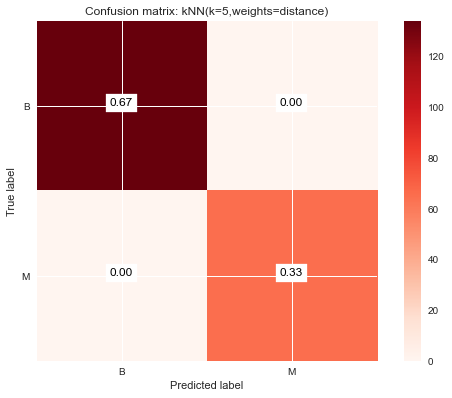

# 199
Saving figure at <D:\Studium\Code\ml-exercises\exercise2\figures\breastcancer\confusion_matrices\CM_knn8_uniform.png>
Accuracy  =     0.975
Precision =     1.000
Recall    =     0.923
F1_score  =     0.960


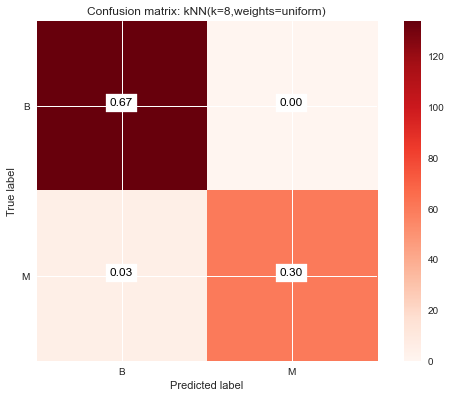

In [96]:
params5 = {"k": 5, "weights":"distance"}
knn5 = KNeighborsClassifier(n_neighbors=params5["k"], weights=params5["weights"])
knn5.fit(X_train_nodrop, Y_train_nodrop)
Y_pred = knn5.predict(X_train_nodrop)
score_knn5 = accuracy_score(Y_train_nodrop, Y_pred)
cm_knn5 = confusion_matrix(Y_train_nodrop, Y_pred)
plot_confusion_matrix(cm_knn5,  ["B", "M"],
                          normalize = True,
                          title = 'Confusion matrix: kNN(k=5,weights=distance)',
                          cmap = plt.cm.Reds)
savefig("confusion_matrices\\CM_knn5_distance.png")
metrics_knn = show_metrics(cm_knn5)
plt.show() 

params8 = {"k": 8, "weights":"uniform"}
knn8 = KNeighborsClassifier(n_neighbors=params8["k"], weights=params8["weights"])
knn8 = KNeighborsClassifier(n_neighbors=8)
knn8.fit(X_train_nodrop, Y_train_nodrop)
Y_pred = knn8.predict(X_train_nodrop)
score_knn8 = accuracy_score(Y_train_nodrop, Y_pred)
cm_knn8 = confusion_matrix(Y_train_nodrop, Y_pred)
plot_confusion_matrix(cm_knn8,  ["B", "M"],
                          normalize = True,
                          title = 'Confusion matrix: kNN(k=8,weights=uniform)',
                          cmap = plt.cm.Reds)
savefig("confusion_matrices\\CM_knn8_uniform.png")
metrics_knn = show_metrics(cm_knn8)
plt.show()

models_knn_selection_nodrop = [(knn5, cm_knn5, params5.copy()), (knn8, cm_knn8, params8.copy())]

# On test set

In [225]:
df_test_full = pd.read_csv('Datasets/breastcancer/breast-cancer-diagnostic.shuf.tes.csv')
df_test_full.head()

,ID,radiusMean,textureMean,perimeterMean,areaMean,smoothnessMean,compactnessMean,concavityMean,concavePointsMean,symmetryMean,...,radiusWorst,textureWorst,perimeterWorst,areaWorst,smoothnessWorst,compactnessWorst,concavityWorst,concavePointsWorst,symmetryWorst,fractalDimensionWorst
0,91805,8.571,13.10,54.53,221.3,0.10360,0.07632,0.02565,0.01510,0.1678,...,9.473,18.45,63.30,275.6,0.1641,0.2235,0.1754,0.08512,0.2983,0.10490
1,87163,13.430,19.63,85.84,565.4,0.09048,0.06288,0.05858,0.03438,0.1598,...,17.980,29.87,116.60,993.6,0.1401,0.1546,0.2644,0.11600,0.2884,0.07371
2,864018,11.340,21.26,72.48,396.5,0.08759,0.06575,0.05133,0.01899,0.1487,...,13.010,29.15,83.99,518.1,0.1699,0.2196,0.3120,0.08278,0.2829,0.08832
3,91930402,20.470,20.67,134.70,1299.0,0.09156,0.13130,0.15230,0.10150,0.2166,...,23.230,27.15,152.00,1645.0,0.1097,0.2534,0.3092,0.16130,0.3220,0.06386
4,86208,20.260,23.03,132.40,1264.0,0.09078,0.13130,0.14650,0.08683,0.2095,...,24.220,31.59,156.10,1750.0,0.1190,0.3539,0.4098,0.15730,0.3689,0.08368


In [226]:
df_test, cols_test = process_data_bc(df_test_full, features_to_drop=feats_to_drop, class_in_data=False) # no class in test data
print("cols_test:", cols_test)
df_test

df_test_nodrop, cols_test_nodrop = process_data_bc(df_test_full, features_to_drop=None, class_in_data=False) # no class in test data
print("cols_test:", cols_test_nodrop)
df_test_nodrop

cols_test: {'ID': 'ID', 'features': Index(['radiusMean', 'textureMean', 'compactnessMean', 'concavityMean',
       'concavePointsMean', 'radiusStdErr', 'compactnessStdErr',
       'concavePointsStdErr', 'compactnessWorst', 'concavityWorst',
       'concavePointsWorst'],
      dtype='object')}
cols_test: {'ID': 'ID', 'features': Index(['radiusMean', 'textureMean', 'perimeterMean', 'areaMean',
       'smoothnessMean', 'compactnessMean', 'concavityMean',
       'concavePointsMean', 'symmetryMean', 'fractalDimensionMean',
       'radiusStdErr', 'textureStdErr', 'perimeterStdErr', 'areaStdErr',
       'smoothnessStdErr', 'compactnessStdErr', 'concavityStdErr',
       'concavePointsStdErr', 'symmetryStdErr', 'fractalDimensionStdErr',
       'radiusWorst', 'textureWorst', 'perimeterWorst', 'areaWorst',
       'smoothnessWorst', 'compactnessWorst', 'concavityWorst',
       'concavePointsWorst', 'symmetryWorst', 'fractalDimensionWorst'],
      dtype='object')}


,ID,radiusMean,textureMean,perimeterMean,areaMean,smoothnessMean,compactnessMean,concavityMean,concavePointsMean,symmetryMean,...,radiusWorst,textureWorst,perimeterWorst,areaWorst,smoothnessWorst,compactnessWorst,concavityWorst,concavePointsWorst,symmetryWorst,fractalDimensionWorst
0,91805,-1.550919,-1.426697,-1.508990,-1.198796,0.467919,-0.535939,-0.788193,-0.861831,-0.531874,...,-1.386280,-1.174350,-1.282919,-1.035560,1.371600,-0.217947,-0.480331,-0.470837,0.148158,1.208531
1,87163,-0.257577,0.083433,-0.307971,-0.308779,-0.429901,-0.772463,-0.401461,-0.405157,-0.839524,...,0.241910,0.678351,0.168929,0.087127,0.328154,-0.641793,-0.067422,-0.014673,-0.029844,-0.591453
2,864018,-0.813882,0.460387,-0.820447,-0.745640,-0.627667,-0.721955,-0.486605,-0.769691,-1.266388,...,-0.709319,0.561543,-0.719340,-0.656380,1.623766,-0.241938,0.153415,-0.505404,-0.128735,0.251694
3,91930402,1.616292,0.323944,1.566247,1.588680,-0.355995,0.431628,0.699193,1.184672,1.344790,...,1.246730,0.237077,1.133195,1.105677,-0.993544,-0.034014,0.140424,0.654506,0.574286,-1.159900
4,86208,1.560395,0.869718,1.478022,1.498153,-0.409371,0.431628,0.631077,0.837193,1.071751,...,1.436210,0.957392,1.244876,1.269858,-0.589208,0.584223,0.607150,0.595417,1.417552,-0.016082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,903554,-0.611589,-0.358274,-0.606020,-0.617091,0.420017,-0.161794,-0.527710,-0.431686,0.464142,...,-0.604052,0.018063,-0.601122,-0.591645,0.462933,-0.502152,-0.550386,-0.802620,0.266827,-0.758813
280,88725602,0.301389,3.304889,0.377120,0.155498,0.652683,1.005339,0.966957,0.769924,1.056368,...,0.339521,3.869474,0.433149,0.151862,2.423741,1.829924,1.351777,1.246869,1.099304,2.103040
281,865423,2.622431,0.215251,2.774554,2.783645,3.280448,3.166437,3.922938,3.546204,3.225300,...,1.780720,-0.275579,1.920407,1.774911,1.610723,1.017911,1.398171,1.592538,0.577882,-0.223262
282,925622,0.218875,2.624984,0.365612,0.083076,0.550036,1.793753,1.905308,1.013893,1.198656,...,0.153869,2.774401,0.498523,-0.035774,0.397717,3.277397,4.134039,1.752077,2.136755,3.286101


In [227]:
models_mlp_selection

[(MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
                beta_2=0.999, early_stopping=False, epsilon=1e-08,
                hidden_layer_sizes=11, learning_rate='constant',
                learning_rate_init=0.001, max_fun=15000, max_iter=10000,
                momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
                power_t=0.5, random_state=None, shuffle=True, solver='adam',
                tol=1e-09, validation_fraction=0.1, verbose=False,
                warm_start=False),
  array([[53,  0],
         [ 3, 30]], dtype=int64),
  {'h': 11,
   'alpha': 1e-05,
   'mode': 'relu',
   'solver': 'adam',
   'score': 0.9767441860465116,
   'traintime': 5.094166040420532}),
 (MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
                beta_2=0.999, early_stopping=False, epsilon=1e-08,
                hidden_layer_sizes=30, learning_rate='constant',
                learning_rate_init=0.001, max_fun=15000, 

In [228]:
models_knn_selection_nodrop

[(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                       metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                       weights='distance'),
  array([[134,   0],
         [  0,  65]], dtype=int64),
  {'k': 5, 'weights': 'distance'}),
 (KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                       metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                       weights='uniform'),
  array([[134,   0],
         [  5,  60]], dtype=int64),
  {'k': 8, 'weights': 'uniform'})]

In [231]:
clf = models_knn_selection_reduced[0][0]# models_mlp_selection[0]
results = clf.predict(df_test[cols_test["features"]])
y_test = pd.concat([pd.DataFrame(df_test["ID"], columns=["ID"]), pd.DataFrame(results, columns=["MALIGNANT"])], axis=1)
y_test.to_csv(f"results/breastcancer/MALIGNANT_knn_reduced_bc_sol.csv", columns=["ID", "MALIGNANT"], index=False)

clf = models_knn_selection_nodrop[0][0]
results_nodrop = clf.predict(df_test_nodrop[cols_test_nodrop["features"]])
y_test_nodrop = pd.concat([pd.DataFrame(df_test_nodrop["ID"], columns=["ID"]), pd.DataFrame(results_nodrop, columns=["MALIGNANT"])], axis=1)    
y_test_nodrop.to_csv(f"results/breastcancer/MALIGNANT_knn_nodrop_bc_sol.csv", columns=["ID", "MALIGNANT"], index=False)

In [ ]:
clf = model_rftest_reduced[]
clf

In [ ]:
model_rftest_reduced = models_rf_reduced[11]
model_rftest_nodrop = models_rf_nodrop[5]

clf = model_rftest_reduced[0]
clf.fit(X_train, Y_train)
results = clf.predict(df_test[cols_test["features"]])
y_test = pd.concat([pd.DataFrame(df_test["ID"], columns=["ID"]), pd.DataFrame(results, columns=["MALIGNANT"])], axis=1)
y_test.to_csv(f"results/breastcancer/MALIGNANT_RF_reduced_bc_sol.csv", columns=["ID", "MALIGNANT"], index=False)

clf = model_rftest_nodrop[0]
clf.fit(X_train_nodrop, Y_train_nodrop)
results_nodrop = clf.predict(df_test_nodrop[cols_test_nodrop["features"]])
y_test_nodrop = pd.concat([pd.DataFrame(df_test_nodrop["ID"], columns=["ID"]), pd.DataFrame(results_nodrop, columns=["MALIGNANT"])], axis=1)    
y_test_nodrop.to_csv(f"results/breastcancer/MALIGNANT_RF_nodrop_bc_sol.csv", columns=["ID", "MALIGNANT"], index=False)

In [ ]:
classifiers = [("RandomForest", rf), ("MLP", mlp), ("kNN", knn)]
y_test = {"RandomForest": None, "MLP": None, "kNN": None}
y_test_encoded = {"RandomForest": None, "MLP": None, "kNN": None}
scores = {"RandomForest": None, "MLP": None, "kNN": None}

for name, clf in classifiers:
    results = clf.predict(df_test[cols_test["features"]])
    y_test[name] = pd.concat([pd.DataFrame(df_test["ID"], columns=["ID"]), pd.DataFrame(results, columns=["class"])], axis=1)
    y_test_encoded[name] = encode(y_test[name], "class", (0, "B"), val_else="M")
print()
display(y_test["RandomForest"].head())
print()
display(y_test_encoded["RandomForest"].head())

In [ ]:
fig, axis = plt.subplots(ncols=3, sharey=True,figsize=(15,5))
for key, ax in zip(y_test, axis):
    ax.hist( [ y_test_encoded[key]["class"][y_test_encoded[key]["class"]=="B"], y_test_encoded[key]["class"][y_test_encoded[key]["class"]=="M"]], color=["r", "g"], label=["B", "M"], bins=2)
    ax.set_title(key)
    ax.legend()
plt.tight_layout()
#plt.legend()
print("Red...B", "Green...M")

In [ ]:
for model_name in y_test:
    y_test[model_name].columns = ["ID", "MALIGNANT"]
    y_test[model_name].to_csv(f"results/breastcancer/MALIGNANT_{model_name}_bc_sol.csv", columns=["ID", "MALIGNANT"], index=False)